# Analysis of results from Toloka survey

# Imports and installs

In [54]:
!pip3 install python-Levenshtein
!pip3 install seaborn
import pandas as pd
import numpy as np 
import datetime
import json
import copy
import Levenshtein
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

# For JSON
from ast import literal_eval

# To be able to import from other notebook
!pip3 install nbimporter
import nbimporter
from extraction import extract_data

# Remove warning
pd.options.mode.chained_assignment = None

# For plotting
plt.rcParams['axes.facecolor']='white'  # to have white background
plt.rcParams['savefig.facecolor']='white'  # to have white background
hex1, hex2, hex3, hex4 = '#79ccb3', '#92cad1', '#e9724d', '#868686'
large_fontsize = 35
medium_fontsize = 25
small_fontsize = 15

raw = pd.read_json("data/kym.json")        # meme templates from Know Your Meme
events = pd.read_json("data/events.json")  # memes with timestamps from origin and spread
memes = extract_data(raw, events)

# Q1: Have you used this meme before?
# Q2: Have you seen others use this meme?
# Q3: Do you relate to this meme?

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.

# Data selection and general visuals

### Select relevant columns and clean data

In [2]:
results = pd.read_csv("data/toloka_results.tsv", sep="\t")
results = results.drop(columns=['INPUT:image', 'OUTPUT:captcha', 'OUTPUT:text_review_mode', 'GOLDEN:q1', 'GOLDEN:q2', 'GOLDEN:q3', 'GOLDEN:result', 'GOLDEN:captcha', 'GOLDEN:reaction', 'GOLDEN:snowclone', 'GOLDEN:exploitable', 'GOLDEN:text_review_mode', 'HINT:text', 'HINT:default_language', 'ASSIGNMENT:link', 'ASSIGNMENT:task_id', 'ASSIGNMENT:assignment_id', 'ASSIGNMENT:worker_id', 'ASSIGNMENT:status'])
results['OUTPUT:result'] = results['OUTPUT:result'].apply(lambda x: json.loads(x))

# Convert multiple-choice answers to boolean
results['OUTPUT:q1'] = results['OUTPUT:q1'].map({'1y': True, '1n': False})
results['OUTPUT:q2'] = results['OUTPUT:q2'].map({'2y': True, '2n': False})
results['OUTPUT:q3'] = results['OUTPUT:q3'].map({'3y': True, '3n': False})

# Calculate time taken per assignment
results['ASSIGNMENT:submitted'] = pd.to_datetime(results['ASSIGNMENT:submitted'])
results['ASSIGNMENT:started'] = pd.to_datetime(results['ASSIGNMENT:started'])
results['minutes_taken'] = results['ASSIGNMENT:submitted'] - results['ASSIGNMENT:started']
results['minutes_taken'] = results['minutes_taken'].apply(lambda x: round(x.total_seconds() / 60, 2))
results = results.drop(columns=['ASSIGNMENT:started', 'ASSIGNMENT:submitted'])

results.head()

,INPUT:input,INPUT:memelink,OUTPUT:q1,OUTPUT:q2,OUTPUT:q3,OUTPUT:result,OUTPUT:reaction,OUTPUT:snowclone,OUTPUT:exploitable,minutes_taken
0,Autistic Screeching is an exploitable comic se...,https://knowyourmeme.com/memes/autistic-screec...,False,False,False,"{'Title': ['Autistic Screeching', '""autistic s...",False,True,False,8.59
1,"No Items, Fox Only, Final Destination is a cat...",https://knowyourmeme.com/memes/no-items-fox-on...,False,False,False,"{'Title': ['No Items, Fox Only, Final Destinat...",True,False,False,5.60
2,Lie Down / Try Not to Cry / Cry a Lot refers a...,https://knowyourmeme.com/memes/lie-down-try-no...,False,False,False,"{'Title': ['Lie Down', 'Try Not to Cry', 'Cry ...",True,False,False,2.71
3,Autistic Screeching is an exploitable comic se...,https://knowyourmeme.com/memes/autistic-screec...,False,False,False,"{'Title': ['Autistic Screeching'], 'Meaning': ...",True,False,False,6.74
4,Y'all Consider This A Date? refers to a series...,https://knowyourmeme.com/memes/yall-consider-t...,False,False,False,"{'Title': ['Y'all Consider This A Date?'], 'Me...",False,False,True,9.53


## Time taken for annotation

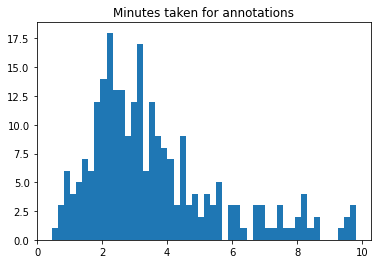

In [3]:
# Plot time taken for annotations (in minutes)
plt.hist(results['minutes_taken'], bins = 50)
# plt.bar(results['minutes_taken'], bins = len(results))
plt.title("Minutes taken for annotations")
plt.show()

## Analysis of multiple-choice answers

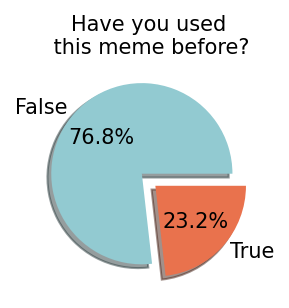

In [4]:
# Add year as separate column
from collections import Counter
plt.rcParams['figure.figsize'] = [2, 2]
plt.rcParams['figure.dpi'] = 150

plot_data = Counter(results['OUTPUT:q1'])

plt.figure(figsize=(2, 2), dpi=150)
plt.pie(x = plot_data.values(), labels = plot_data.keys(), colors=[hex2, hex3], autopct='%1.1f%%', shadow=True, explode=(0.1, 0.1))
# plt.ylabel('Total number', fontsize=medium_fontsize)
# plt.xlabel('Year', fontsize=medium_fontsize)
plt.title("Have you used\n this meme before?", fontsize=large_fontsize - 25)
# plt.xticks(ticks=[0,1], labels=["False", "True"], fontsize=small_fontsize)
# plt.yticks(fontsize=small_fontsize)
# plt.xlim([-1,len(plot_data.keys())])
# plt.set_size_inches(8, 6)
# plt.savefig('graphs/multiple_choice/q1.png', bbox_inches='tight')
plt.show()

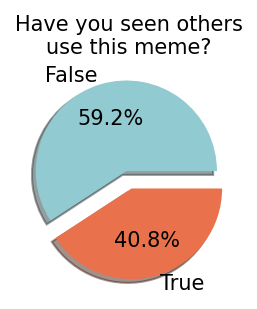

In [5]:
plot_data = Counter(results['OUTPUT:q2'])

plt.figure(figsize=(2, 2), dpi=150)
plt.pie(x = plot_data.values(), labels = plot_data.keys(), colors=[hex2, hex3], autopct='%1.1f%%', shadow=True, explode=(0.1, 0.1))
# plt.ylabel('Total number', fontsize=medium_fontsize)
# plt.xlabel('Year', fontsize=medium_fontsize)
plt.title("Have you seen others\nuse this meme?", fontsize=large_fontsize - 25)
# plt.xticks(ticks=[0,1], labels=["False", "True"], fontsize=small_fontsize)
# plt.yticks(fontsize=small_fontsize)
# plt.xlim([-1,len(plot_data.keys())])
# plt.savefig('graphs/multiple_choice/q2.png', bbox_inches='tight')
plt.show()

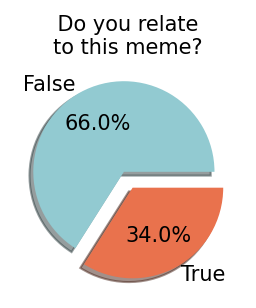

In [6]:
plot_data = Counter(results['OUTPUT:q3'])

plt.figure(figsize=(2, 2), dpi=150)
plt.pie(x = plot_data.values(), labels = plot_data.keys(), colors=[hex2, hex3], autopct='%1.1f%%', shadow=True, explode=(0.1, 0.1))
# plt.ylabel('Total number', fontsize=medium_fontsize)
# plt.xlabel('Year', fontsize=medium_fontsize)
plt.title("    Do you relate    \n     to this meme?     ", fontsize=large_fontsize - 25)
# plt.xticks(ticks=[0,1], labels=["False", "True"], fontsize=small_fontsize)
# plt.yticks(fontsize=small_fontsize)
# plt.xlim([-1,len(plot_data.keys())])
# plt.savefig('graphs/multiple_choice/q3.png', bbox_inches='tight')
plt.show()

In [7]:
# Agreement between questions
agreement = results['OUTPUT:q2'] == results['OUTPUT:q3']
agreement = [1 if a == b and a == True else 0 for a,b in zip(results['OUTPUT:q2'], results['OUTPUT:q3'])]
print(sum(agreement) / len(agreement))

0.216


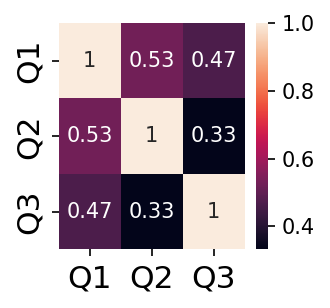

In [8]:
# Correlation between Q1, Q2 and Q3
questions = results[['OUTPUT:q1', 'OUTPUT:q2', 'OUTPUT:q3']]
questions['OUTPUT:q1'] = questions['OUTPUT:q1'].map({True: 1, False: 0})
questions['OUTPUT:q2'] = questions['OUTPUT:q2'].map({True: 1, False: 0})
questions['OUTPUT:q3'] = questions['OUTPUT:q3'].map({True: 1, False: 0})

questions.columns = ['Q1', 'Q2', 'Q3']
corr = questions.corr()
#print(corr)
sn.heatmap(corr, annot=True)
plt.xticks(fontsize=small_fontsize)
plt.yticks(fontsize=small_fontsize)
plt.show()

In [9]:
# Check how often the annotated type matches the type(s) that we have in the dataset (ground truth)
types = results[['INPUT:memelink', 'OUTPUT:reaction', 'OUTPUT:snowclone', 'OUTPUT:exploitable', 'OUTPUT:result']]
types.rename(columns = {'INPUT:memelink':'url'}, inplace = True)
types = pd.merge(types, memes, on="url", how="left")
types = types[['url', 'type', 'OUTPUT:reaction', 'OUTPUT:snowclone', 'OUTPUT:exploitable', 'OUTPUT:result']]

typematch = []
for target, r, s, e in zip(types['type'], types['OUTPUT:reaction'], types['OUTPUT:snowclone'], types['OUTPUT:exploitable']):
    output = set()
    if r == True:
        output.add("reaction")
    if s == True:
        output.add("snowclone")
    if e == True:
        output.add("exploitable")
    if len(output.intersection(set(target))) > 0:
        typematch.append(1)
    else:
        typematch.append(0)
    
print("Percentage of annotations that got the type right:", sum(typematch) / len(typematch))

Percentage of annotations that got the type right: 0.6


In [10]:
# TODO check agreement between annotators for a meme's type (there are 5 annotations, what percentage of them match? – not sure how to measure)

# Highlights

## General visualizations

In [11]:
# TODO Average length of highlights (overall and per meme?) – for title and for meaning separately

In [12]:
# TODO Average number of highlights (overall and per meme?) – for title and for meaning separately

## Evaluate agreement of Toloka highlights: MEANING

### Rank by standard deviation of NUMBER of annotations

In [13]:
annotations = {key:[] for key in set(results['INPUT:memelink'])}
for url, highlights in zip(results['INPUT:memelink'], results['OUTPUT:result']):
    annotations[url].append(highlights)

# Number of annotations for Meaning
num_annotations = {key:[] for key in set(results['INPUT:memelink'])}
for key, val in annotations.items():
    num_annotations[key] = [len(x['Meaning']) if 'Meaning' in x.keys() else 0 for x in val]

# Rank the annotation similarity by standard deviation of NUMBER of annotations
std_annotations = {key:0 for key in set(results['INPUT:memelink'])}
for key, val in num_annotations.items():
    std_annotations[key] = np.std(val)
std_annotations = dict(sorted(std_annotations.items(), key=lambda item: item[1]))
print("Standard deviation of NUMBER of annotations (meaning):\n", std_annotations)

Standard deviation of NUMBER of annotations (meaning):
 {'https://knowyourmeme.com/memes/the-deathbulge-party-saga': 0.0, 'https://knowyourmeme.com/memes/is-this-a-pigeon': 0.0, 'https://knowyourmeme.com/memes/thats-where-youre-wrong-kiddo': 0.0, 'https://knowyourmeme.com/memes/pennywise-the-clown': 0.0, 'https://knowyourmeme.com/memes/oh-no-its-retarded': 0.0, 'https://knowyourmeme.com/memes/modern-society-parodies': 0.0, 'https://knowyourmeme.com/memes/ideal-gf': 0.0, 'https://knowyourmeme.com/memes/misinformationalized-you-hear-about-video-games': 0.0, 'https://knowyourmeme.com/memes/ew-i-stepped-in-shit': 0.0, 'https://knowyourmeme.com/memes/bitches-love-smiley-faces': 0.0, 'https://knowyourmeme.com/memes/dont-say-youre-a-fan-if-you-dont-know-who-this-is': 0.0, 'https://knowyourmeme.com/memes/repost-if-x': 0.0, 'https://knowyourmeme.com/memes/coincidence-i-think-not': 0.0, 'https://knowyourmeme.com/memes/imminent-ned-brace-yourselves-winter-is-coming': 0.4, 'https://knowyourmeme.co

### Rank by standard deviation of AVERAGE LENGTH of annotations

In [14]:
length_annotations = {key:0 for key in set(results['INPUT:memelink'])}
for key, val in annotations.items():
    avg_lengths = []
    for ann in val:
        avg = []
        if 'Meaning' in ann.keys():
            for highlight in ann['Meaning']:
                avg.append(len(highlight))
            avg_lengths.append(sum(avg) / len(avg))
        else:
            avg_lengths.append(0)
    length_annotations[key] = np.std(avg_lengths)
    
length_annotations = dict(sorted(length_annotations.items(), key=lambda item: item[1]))
print("Standard deviation of AVERAGE LENGTH of annotations (meaning):\n", length_annotations)

Standard deviation of AVERAGE LENGTH of annotations (meaning):
 {'https://knowyourmeme.com/memes/modern-society-parodies': 4.758150901348127, 'https://knowyourmeme.com/memes/oh-you-love-x-name-every-y': 5.427706698044765, 'https://knowyourmeme.com/memes/pennywise-the-clown': 5.782732917920384, 'https://knowyourmeme.com/memes/i-was-only-pretending-to-be-retarded': 12.077251342917394, 'https://knowyourmeme.com/memes/your-mother-and-i-will-always-love-you': 17.26962651593832, 'https://knowyourmeme.com/memes/ideal-gf': 18.24938355123263, 'https://knowyourmeme.com/memes/no-items-fox-only-final-destination': 18.30409790183608, 'https://knowyourmeme.com/memes/i-am-altering-the-deal': 18.993098161642237, 'https://knowyourmeme.com/memes/coincidence-i-think-not': 21.30352083576797, 'https://knowyourmeme.com/memes/how-to-talk-to-short-people': 21.509067855209345, 'https://knowyourmeme.com/memes/oh-no-its-retarded': 21.73844520659194, 'https://knowyourmeme.com/memes/cant-argue-with-that-technicall

### Rank by Levenshtein DISTANCE of annotations

#### Make dictionary of all highlights

In [15]:
highlights = {key:[] for key in set(results['INPUT:memelink'])}

for key, val in annotations.items():
    ID = 0
    anns = []
    for ann in val:
        ID += 1
        if 'Meaning' in ann.keys():
            for a in ann['Meaning']:
                anns.append((ID, a))
        else:
            anns.append((ID, "")) # Missing annotations
    highlights[key] = anns

#### Make dictionary of all distances

In [16]:
distances = {key:{} for key in set(results['INPUT:memelink'])}

# Calculate distances
for key, val in highlights.items():
    lev = {}
    for i in range(len(val) - 1):
        for j in range(i + 1, len(val)):
            ann1 = val[i]
            ann2 = val[j]
            if ann1[0] != ann2[0]:
                new_key = "A" + str(ann1[0]) + "-A" + str(ann2[0])
                if new_key in lev.keys():
                    if ann1[1] == "" or ann2[1] == "":
                        lev[new_key].append(-1)
                    else:
                        dist = Levenshtein.distance(ann1[1].strip(" ,.:;-"), ann2[1].strip(" ,.:;-"))
                        lev[new_key].append(dist / max(len(ann1[1]), len(ann2[1])))  # normalize to [0,1], see https://stackoverflow.com/questions/45783385/normalizing-the-edit-distance
                else:
                    if ann1[1] == "" or ann2[1] == "":
                        lev[new_key] = [-1]
                    else:
                        dist = Levenshtein.distance(ann1[1].strip(" ,.:;-"), ann2[1].strip(" ,.:;-"))
                        lev[new_key] = [dist / max(len(ann1[1]), len(ann2[1]))]
    distances[key] = lev
    
# Create flat list with all distances
hist_data = [x for val in distances.values() for x in val.values()]
hist_data = [x for sublist in hist_data for x in sublist if x != -1]
# max_dist = max(hist_data)  # find max for normalization

#### Function that creates a similarity matrix for each meme (all in one array)

In [17]:
def similarity_matrices(similarity_threshold):
    matrices = {}       
    col_names = ['A1', 'A2', 'A3', 'A4', 'A5']
    for key, value in distances.items():
        columns = {key:[] for key in col_names}
        c = 0
        for k, v in value.items():
            l = [x for x in v if x != -1]
            dist =  min(l) if len(l) > 0 else np.nan
            columns[k[:2]].append(dist)

        # Add np.nan to make matrix complete
        for k in columns.keys():
            for i in range(5 - len(columns[k])):
                columns[k].insert(0, np.nan)

        df = pd.DataFrame(columns, index = col_names)    

        # Mirror bottom values to top
        for i in range(1,6):
            label = 'A' + str(i)
            col = df[label]
            row = df.loc[label]
            new_row = []
            for c, r in zip(col, row):
                if c != np.nan:
                    new_row.append(c)
                else:
                    new_row.append(r)
            df.loc[label] = new_row

        # Change diagonal values to 0
        np.fill_diagonal(df.values, 0)

        # Apply similarity threshold
        df = df.applymap(lambda x: 1 if x <= similarity_threshold else 0)

        # Add new row with sum
        df.loc["Total"] = df.sum()

        matrices[key] = df
    return matrices

#### Function that outputs proportion of pairwise annotation matches

In [18]:
def consensus_level(matrix):
    m_sum = 0
    for i, col in enumerate(matrix.columns):
        row = list(matrix.loc[col])
        m_sum += sum(row[i+1:])
    return m_sum / 10

#### Define similarity threshold and consensus percentage

In [19]:
similarity_threshold = 0.2  # If the distance between two annotations is less OR EQUAL than this, they are considered a match
consensus_percentage = 0.6  # If at least X% of the pairwise comparisons are a match, we consider it to have consensus

matrices = similarity_matrices(similarity_threshold)

#### Plot number of memes that match consensus

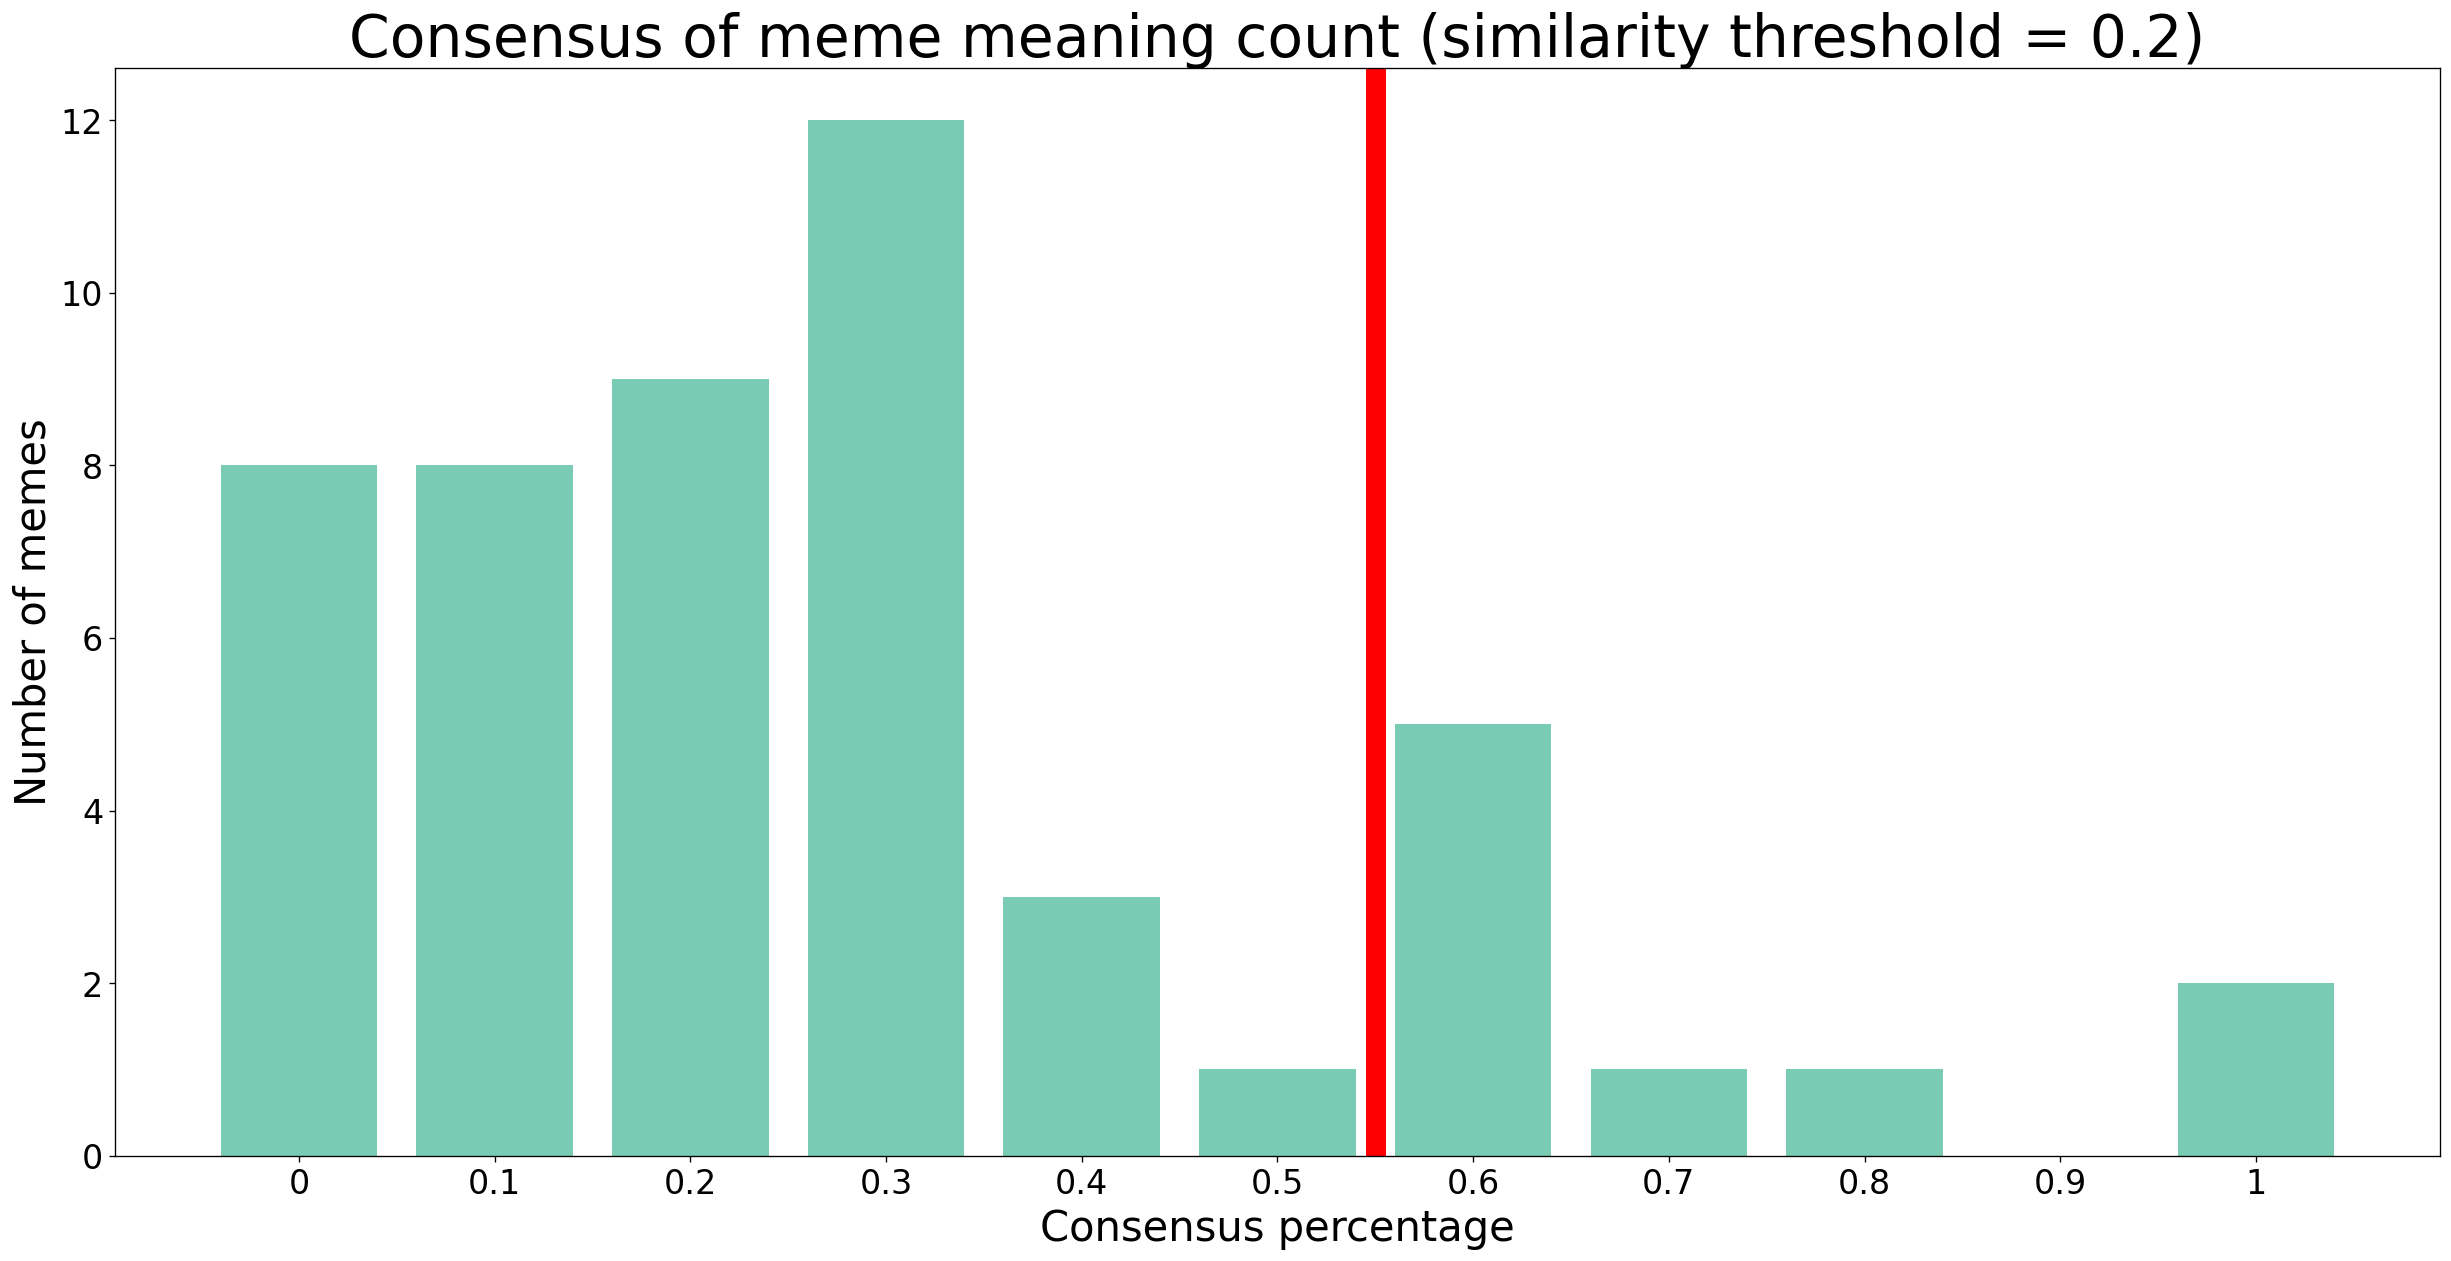

In [20]:
# Calculate consensus for each meme
consensus_data = {}
for key, m in matrices.items():
    proportion = consensus_level(m)
    consensus_data[key] = proportion
    
# Create Counter
consensus_counter = Counter(consensus_data.values())    
    
# Fill in missing values with 0
for i in np.arange(0, 1.1, 0.1):
    i = round(i,1)
    if i not in consensus_counter.keys():
        consensus_counter[i] = 0

# Sort the data
consensus_counter = dict(sorted(consensus_counter.items(), key=lambda item: item[0], reverse=False))

# Visualize
plt.figure(figsize=(25, 12), dpi=120)
plt.bar(['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1'], consensus_counter.values(), color=hex1)
plt.axvline(x=consensus_percentage*10*0.917, color="red", linewidth=12)
plt.ylabel('Number of memes', fontsize=medium_fontsize)
plt.xlabel('Consensus percentage', fontsize=medium_fontsize)
plt.xticks(fontsize=small_fontsize+5)
plt.yticks(fontsize=small_fontsize+5)
plt.title("Consensus of meme meaning count (similarity threshold = {})".format(similarity_threshold), fontsize=large_fontsize)
# plt.savefig('graphs/toloka/meaning/consensus.png', bbox_inches='tight')
plt.show() 

#### Plot number of accepted memes for different similarity thresholds

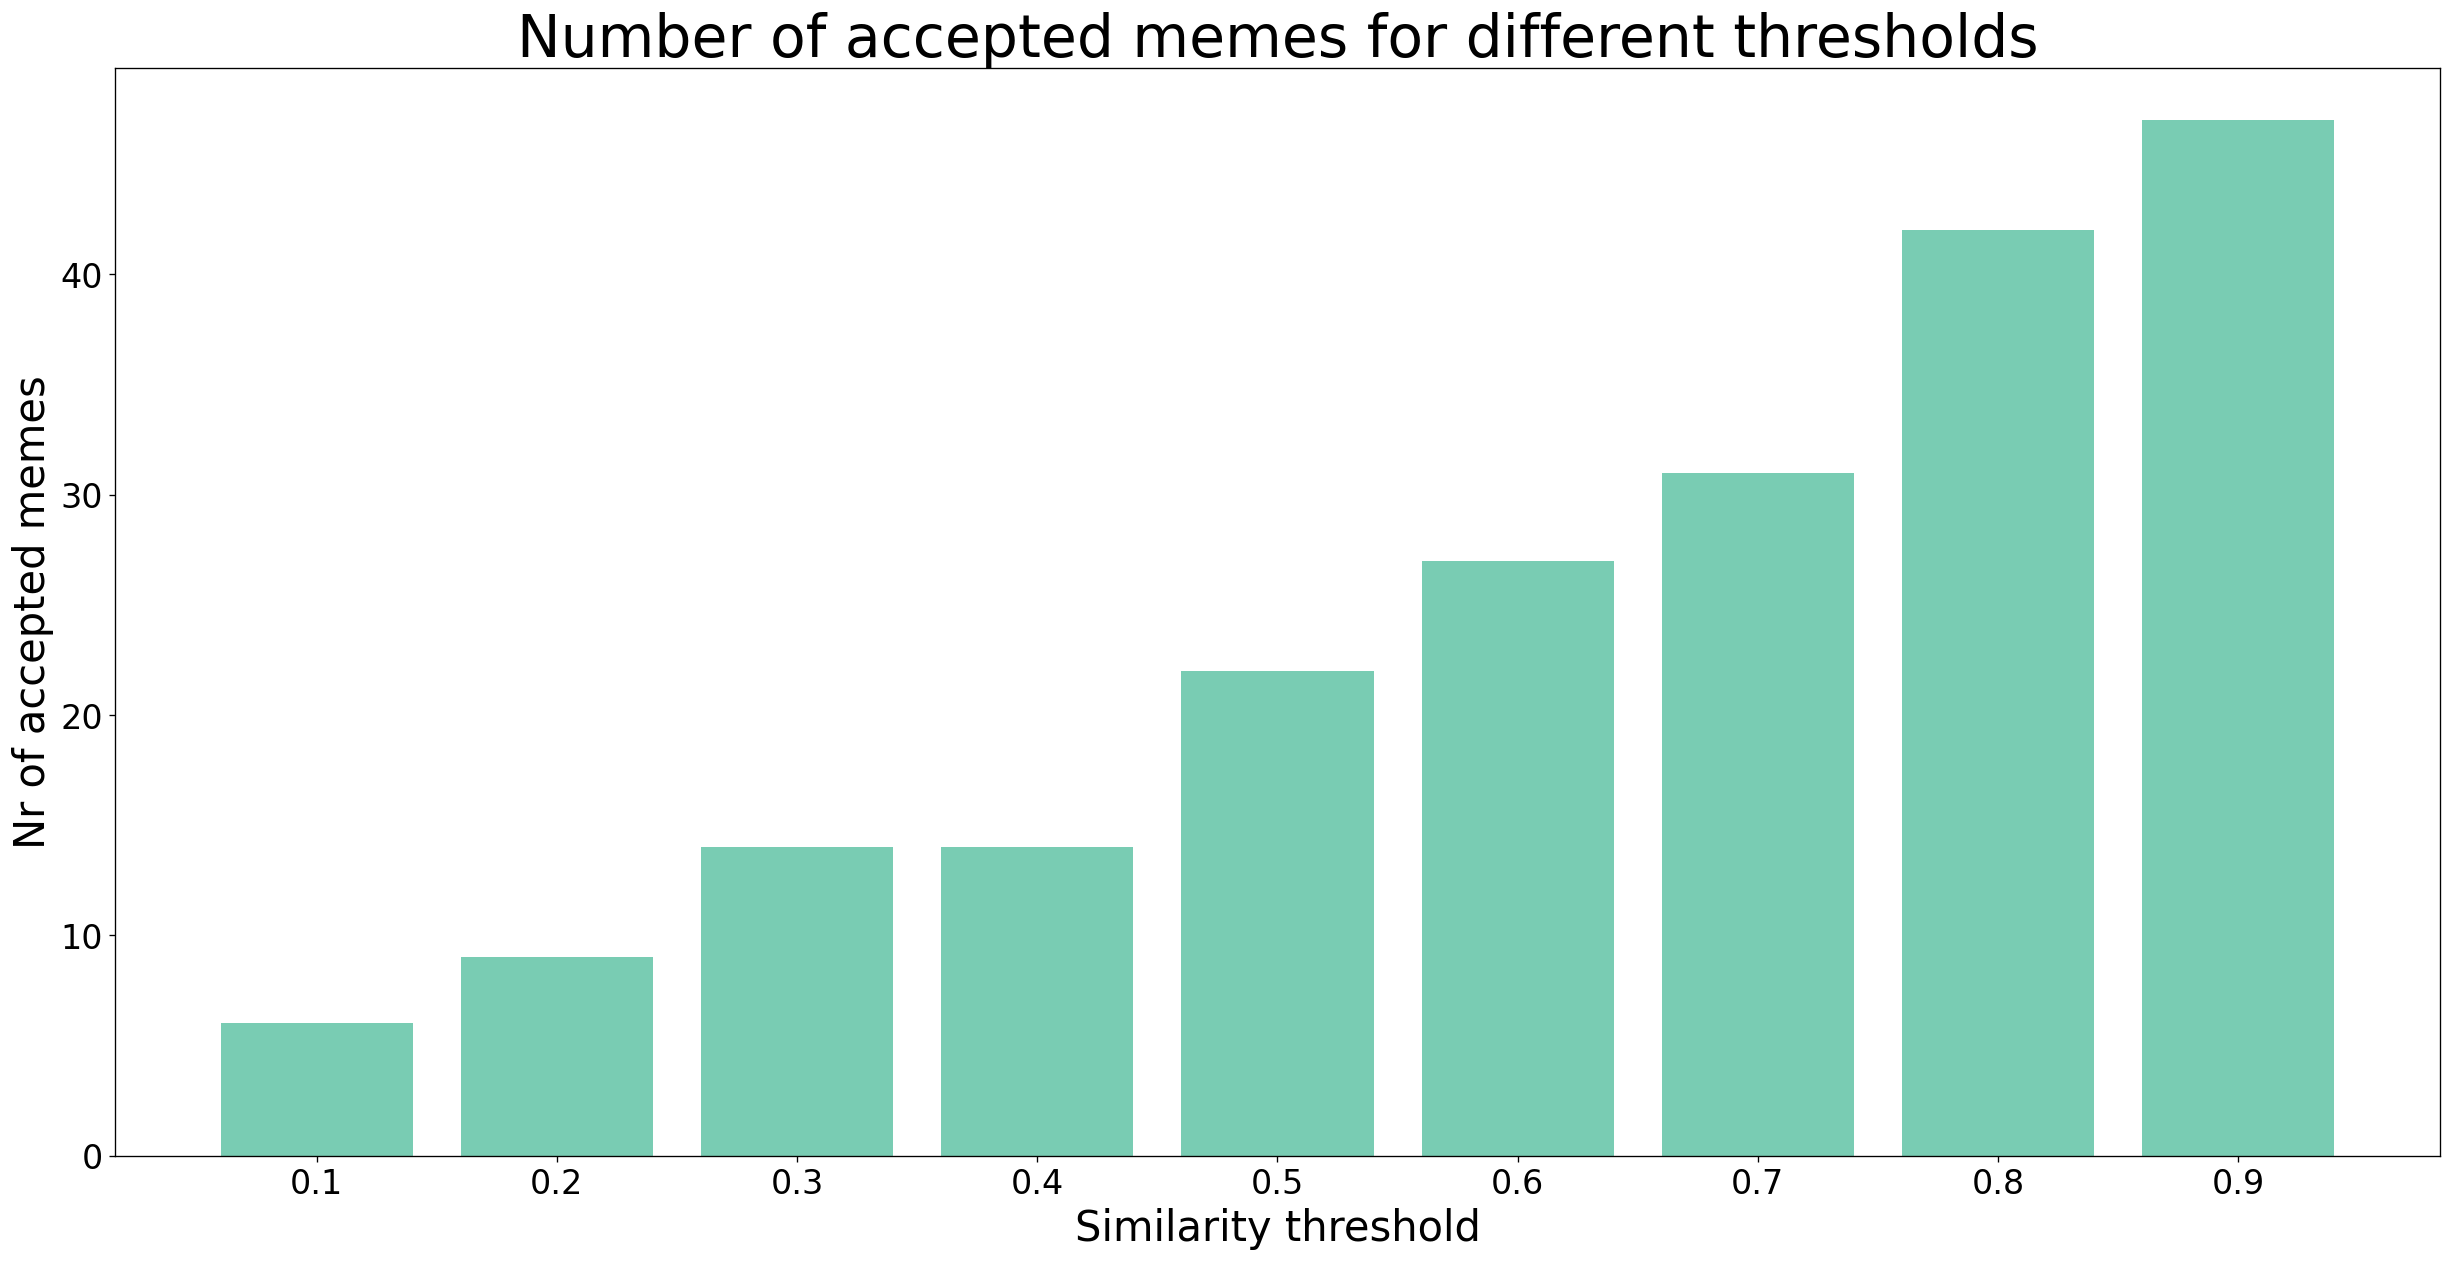

In [21]:
# Get matrices
x_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
y_vals = []

for sim_thresh in x_range:
    matrices = similarity_matrices(sim_thresh)

    # Calculate consensus for each meme
    consensus_data = {}
    for key, m in matrices.items():
        proportion = consensus_level(m)
        consensus_data[key] = proportion

    # Create Counter
    consensus_counter = Counter(consensus_data.values())    

    # Get number of memes that are >= consensus_percentage
    accepted_num = sum([val for key, val in consensus_counter.items() if key >= consensus_percentage])
    y_vals.append(accepted_num)
    

# Visualize
plt.figure(figsize=(25, 12), dpi=120)
plt.bar([str(n) for n in x_range], y_vals, color=hex1)
plt.ylabel('Nr of accepted memes', fontsize=medium_fontsize)
plt.xlabel('Similarity threshold', fontsize=medium_fontsize)
plt.xticks(fontsize=small_fontsize+5)
plt.yticks(fontsize=small_fontsize+5)
plt.title("Number of accepted memes for different thresholds".format(similarity_threshold), fontsize=large_fontsize)
# plt.savefig('graphs/toloka/meaning/similarity_thresholds.png', bbox_inches='tight')
plt.show()

#### Plot levenshtein distance histogram

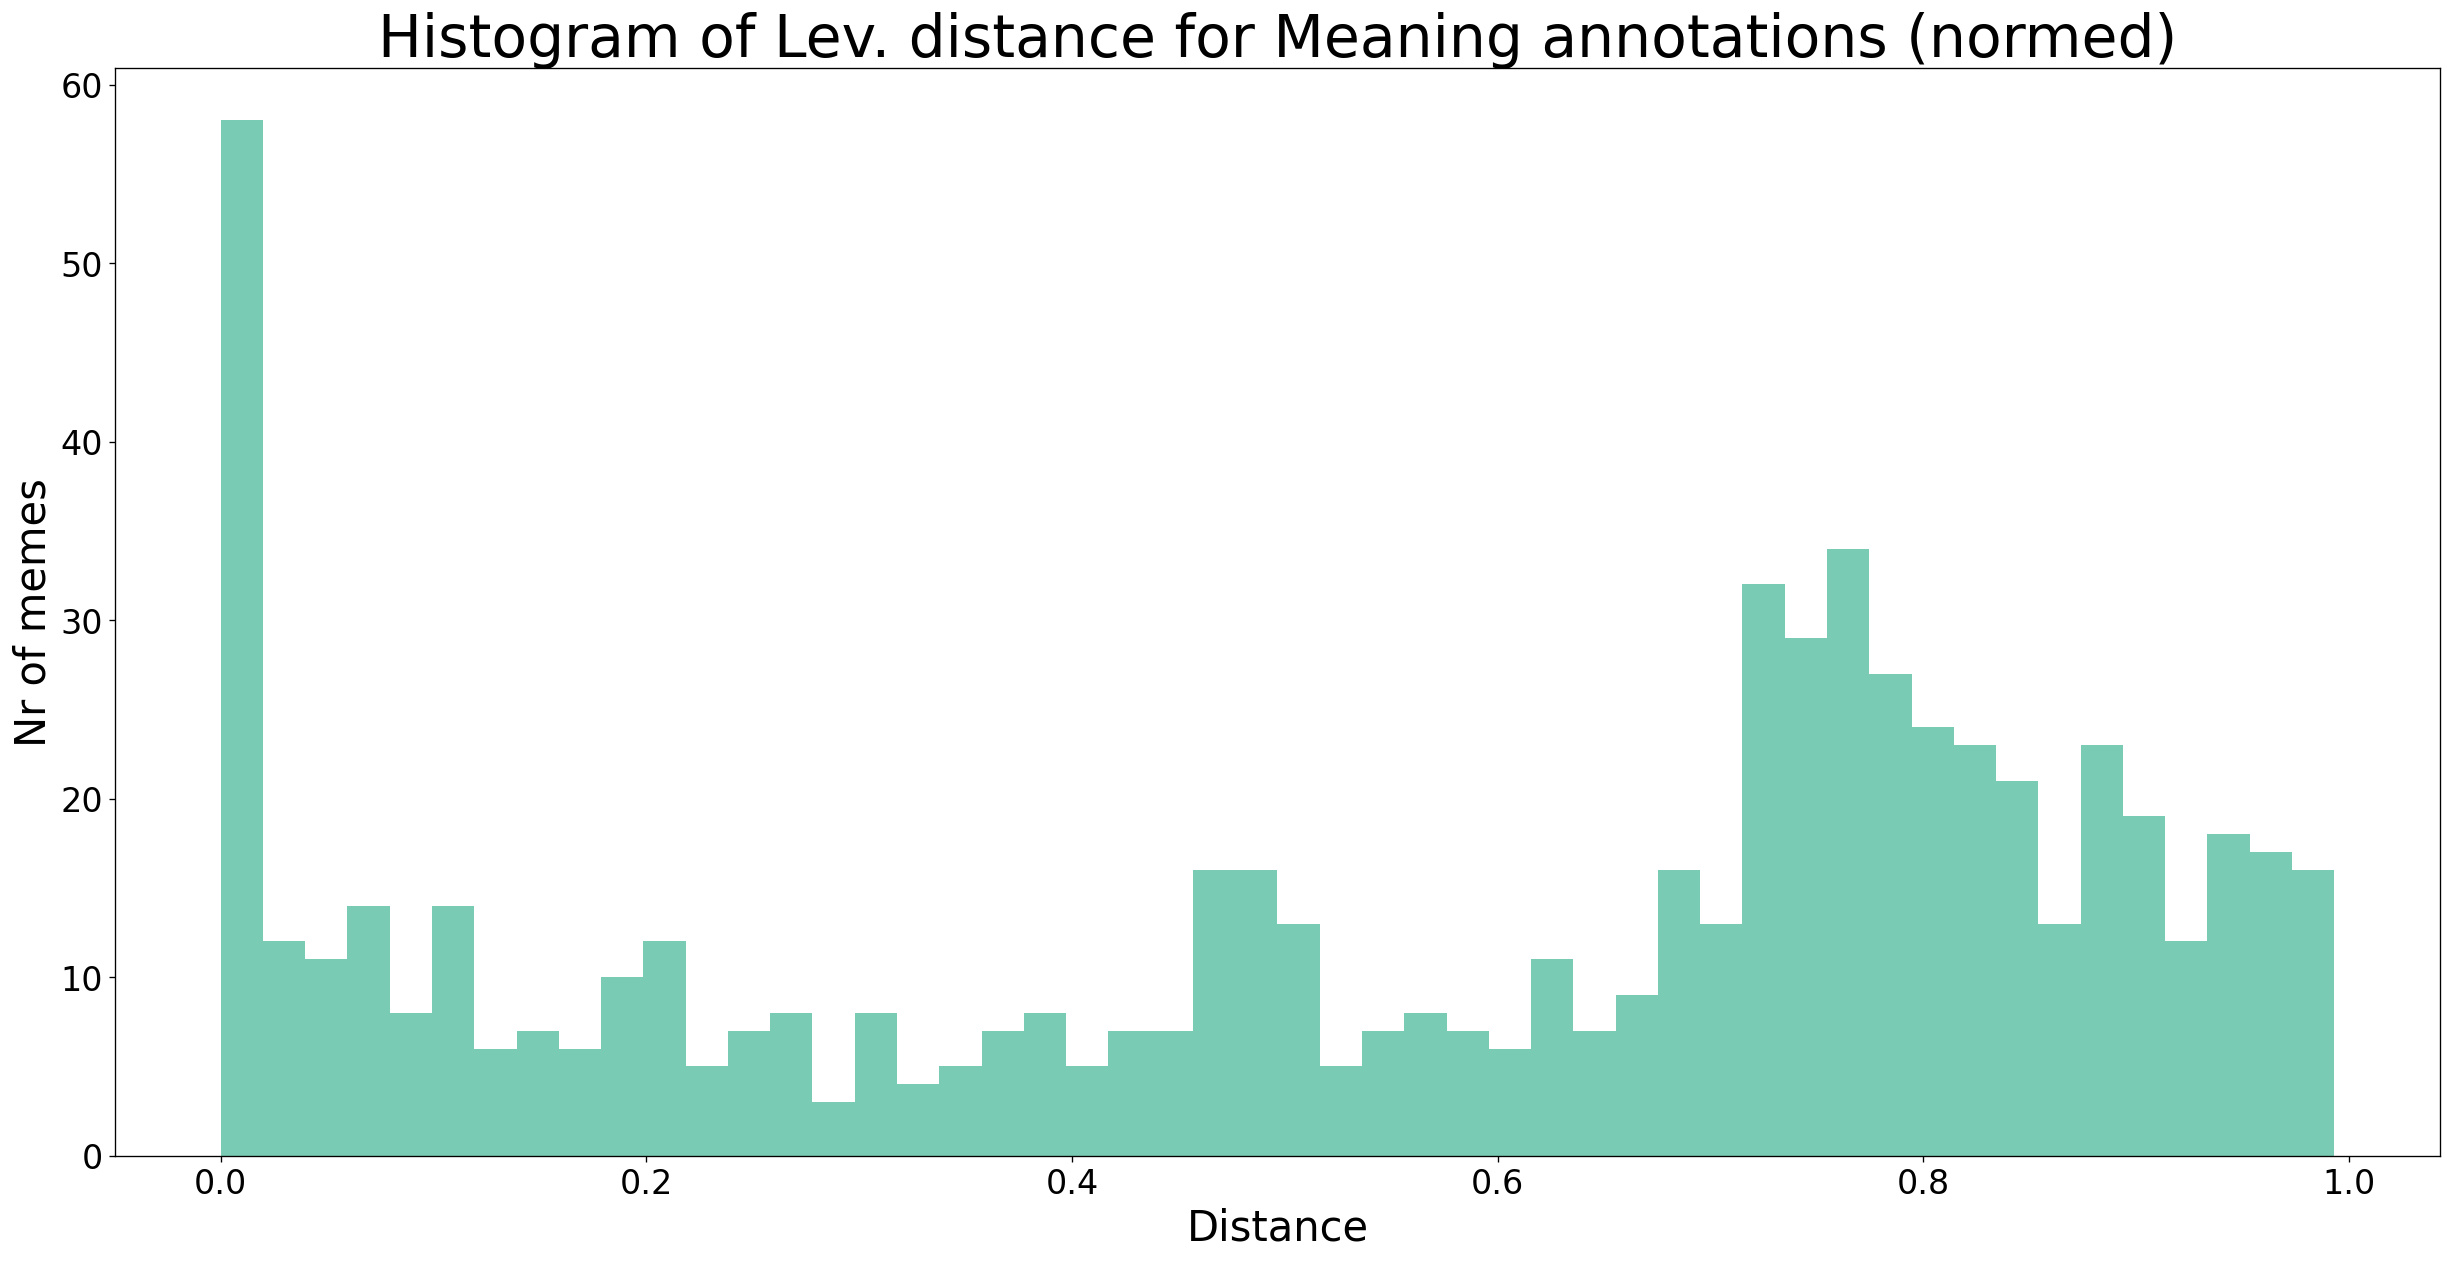

In [22]:
plt.figure(figsize=(25, 12), dpi=120)
plt.hist(hist_data, bins = 50, color=hex1)
plt.title("Histogram of Lev. distance for Meaning annotations (normed)", fontsize=large_fontsize)
plt.ylabel('Nr of memes', fontsize=medium_fontsize)
plt.xlabel('Distance', fontsize=medium_fontsize)
plt.xticks(fontsize=small_fontsize+5)
plt.yticks(fontsize=small_fontsize+5)
# plt.savefig('graphs/toloka/meaning/distance_histogram.png', bbox_inches='tight')
plt.show() 

#### Boxplots of distances for each meme

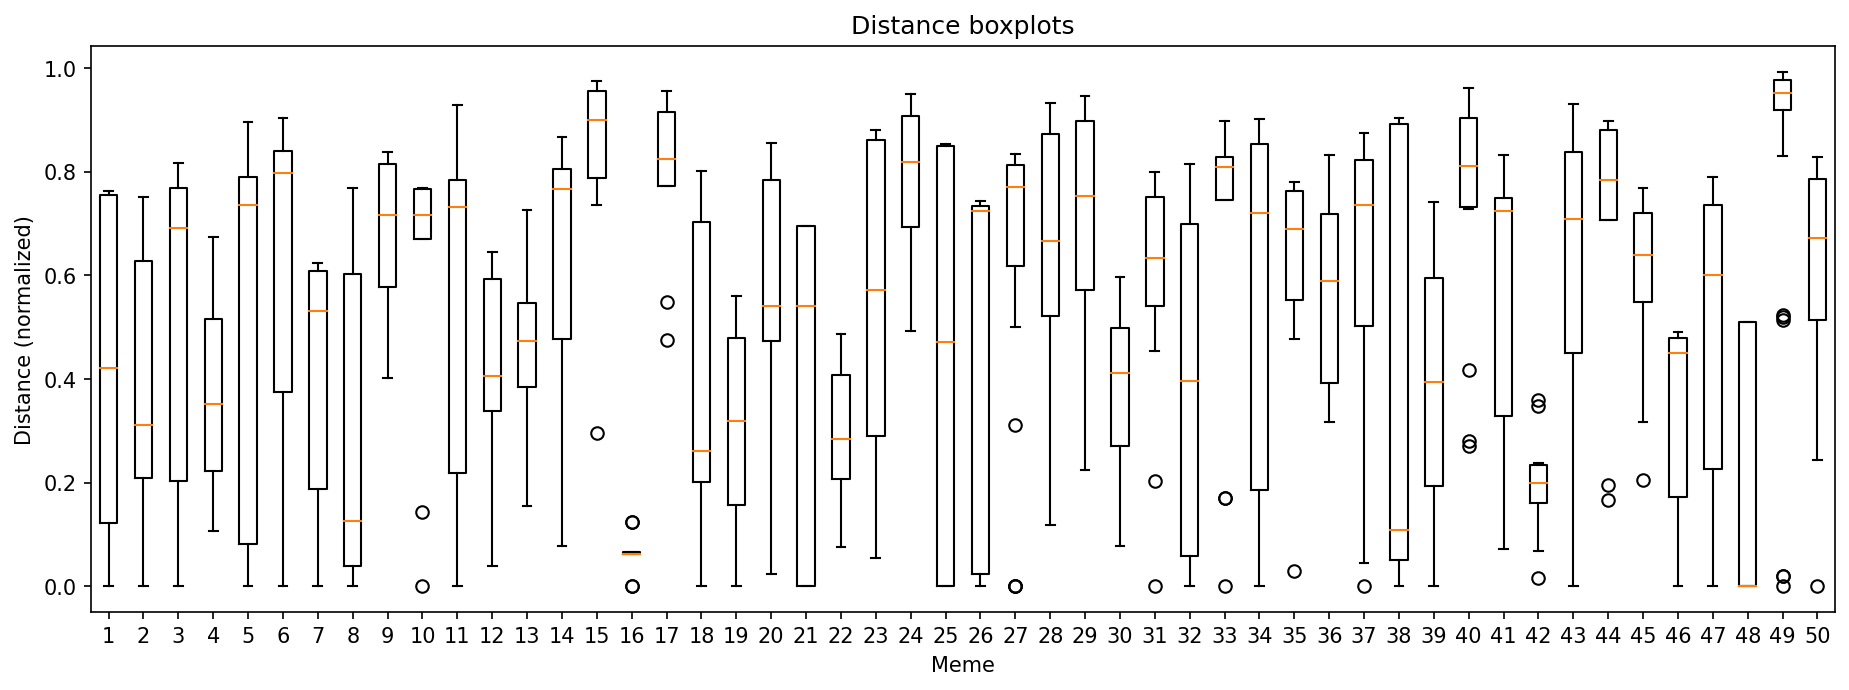

In [32]:
# Boxplot for similarity – all in one (normalized)
distances_per_meme = {key:[dist for dist_list in val.values() for dist in dist_list if dist >= 0] for key, val in distances.items()}

plt.figure(figsize=(15,5))
c = 0
dist_copy = copy.deepcopy(distances_per_meme)
keys = dist_copy.keys()
data = dist_copy.values()
positions = np.arange(1, 51, step=1)
plt.boxplot(data, positions=positions, showfliers=True)
plt.title('Distance boxplots')
plt.ylabel('Distance (normalized)')
plt.xlabel('Meme')
plt.xticks(np.arange(1, 51, step=1))
c += 1
# plt.savefig('graphs/toloka/meaning/boxplots_norm.png')
plt.show() 

In [31]:
# Inspect data based on boxplot
# NB! Indices on the boxplot start from 1, not 0!
distances_list = list(distances_per_meme)
chosen = distances_list[7]
print("Highlights for {}:".format(chosen))
print(highlights[chosen])
# print(distances[chosen])

Highlights for https://knowyourmeme.com/memes/no-items-fox-only-final-destination:
[(1, 'a catchphrase parodying the strict and "serious" behavior of competitive players of the video game series Super Smash Bros., or "Tourneyfags," as they are known'), (2, 'catchphrase parodying the strict and "serious" behavior of competitive players of the video game series Super Smash Bros., or "Tourneyfags'), (2, 'The phrase is commonly edited through the snowclone "No X, Y Only, Final Destination!"'), (3, 'catchphrase parodying the strict and "serious" behavior of competitive players of the video game series Super Smash Bros., or "Tourneyfags,"'), (4, 'catchphrase parodying the strict and "serious" behavior of competitive players of the video game series Super Smash Bros., or "Tourneyfags," as they are known'), (5, 'catchphrase parodying the strict and "serious" behavior of competitive players of the video game series Super Smash Bros., or "Tourneyfags," as they are known')]


## Evaluate agreement of Label Studio vs Toloka annotations

### Prepare data

In [26]:
# Read in and clean data
studio = pd.read_json("data/label_studio.json")
studio = studio[['annotations', 'data']]

# Add url as column
studio['url'] = [data['url'] for data in studio['data']]
studio = studio.drop(columns=['data'])

# Retrieve highlights from Label Studio JSON
ls_highlights = {}
for url, ann in zip(studio['url'], studio['annotations']):
    info = {"Title":[], "Meaning":[], "Type":[]}
    for label in ann[0]['result']:    
        text = label['value']['text']
        category = label['value']['labels'][0]
        if category in ["Meme", "Meaning", "MemeType"]:
            if category == "Meme":
                category = "Title"
            elif category == "MemeType":
                category = "Type"
            info[category].append(text)
    if url in ls_highlights.keys() and len(ls_highlights[url]['Meaning']) >= len(info['Meaning']):  # Some memes are annotated multiple times
        continue
    ls_highlights[url] = info

# Add new column with Label Studio highlights
labelstudio_col = [ls_highlights[url] for url in types['url']]
types['labelstudio'] = labelstudio_col

,url,type,OUTPUT:reaction,OUTPUT:snowclone,OUTPUT:exploitable,OUTPUT:result,labelstudio
0,https://knowyourmeme.com/memes/autistic-screec...,[exploitable],False,True,False,"{'Title': ['Autistic Screeching', '""autistic s...","{'Title': ['Autistic Screeching'], 'Meaning': ..."
1,https://knowyourmeme.com/memes/no-items-fox-on...,"[pop-culture-reference, snowclone]",True,False,False,"{'Title': ['No Items, Fox Only, Final Destinat...","{'Title': ['No Items, Fox Only, Final Destinat..."
2,https://knowyourmeme.com/memes/lie-down-try-no...,[exploitable],True,False,False,"{'Title': ['Lie Down', 'Try Not to Cry', 'Cry ...",{'Title': ['Lie Down / Try Not to Cry / Cry a ...
3,https://knowyourmeme.com/memes/autistic-screec...,[exploitable],True,False,False,"{'Title': ['Autistic Screeching'], 'Meaning': ...","{'Title': ['Autistic Screeching'], 'Meaning': ..."
4,https://knowyourmeme.com/memes/yall-consider-t...,[snowclone],False,False,True,"{'Title': ['Y'all Consider This A Date?'], 'Me...","{'Title': ['Y'all Consider This A Date?'], 'Me..."


In [77]:
# Only keep the 50 LS highlights
ls_highlights = {key:val for key, val in ls_highlights.items() if key in highlights.keys()}

all_highlights = copy.deepcopy(highlights)

# Join LS highlights with Toloka highlights – use ID 0
for key, val in ls_highlights.items():
    if 'Meaning' in val.keys():
        for a in val['Meaning']:
            all_highlights[key].insert(0, (0, a))
    else:
        print("MISSING ANNOTATION!")
    
# print(all_highlights[list(all_highlights.keys())[5]])

### Calculate distances

In [106]:
LS_distances = {key:{} for key in set(types['url'])}

# Calculate distances
for key, val in all_highlights.items():
    lev = {}
    for i in range(len(val) - 1):
        for j in range(i + 1, len(val)):
            ann1 = val[i]
            ann2 = val[j]
            
            # Only calculate distances between LS
            if ann1[0] != 0 and ann2[0] != 0:
                continue
                
            if ann1[0] != ann2[0]:
                new_key = "A" + str(ann1[0]) + "-A" + str(ann2[0])
                if new_key in lev.keys():
                    if ann1[1] == "" or ann2[1] == "":
                        lev[new_key].append(-1)
                    else:
                        dist = Levenshtein.distance(ann1[1].strip(" ,.:;-"), ann2[1].strip(" ,.:;-"))
                        lev[new_key].append(dist / max(len(ann1[1]), len(ann2[1])))  # normalize to [0,1] by dividing by max possible distance for this specific comparison
                else:
                    if ann1[1] == "" or ann2[1] == "":
                        lev[new_key] = [-1]
                    else:
                        dist = Levenshtein.distance(ann1[1].strip(" ,.:;-"), ann2[1].strip(" ,.:;-"))
                        lev[new_key] = [dist / max(len(ann1[1]), len(ann2[1]))]
    LS_distances[key] = lev
    
# Keep only the best distances (some annotations contain multiple highlights)
LS_best_distances = {}

for key, val in LS_distances.items():
    new_distlist = {}
    for name, dist_list in val.items():
        new_distlist[name] = min([x for x in dist_list])
    LS_best_distances[key] = new_distlist

### Inspect high distances

In [ ]:
# Rate whether the distance is accurate in capturing similarity
# My subjective label: 1 – very dissimilar; 2 – somewhat similar; 3 – very similar

dist_thresh = 0.7
print("Showing all distances over {}.\n".format(dist_thresh))
for key, val in LS_best_distances.items():
    print("Title: {}. Url: {}\n".format(key.split("/")[-1], key))
    for name, distance in val.items():
        if distance > dist_thresh:
            print("Distance between {} is {}.".format(name, round(distance, 2)))
            print("My annotation(s):\n", [ann for ann in all_highlights[key] if ann[0] == 0])
            print("\nTheir annotation(s):\n", [ann for ann in all_highlights[key] if ann[0] == int(name[-1])])
            input("\nMy label: ")
            print("-" * 100)

Showing all distances over 0.7.

Title: the-deathbulge-party-saga. Url: https://knowyourmeme.com/memes/the-deathbulge-party-saga

Distance between A0-A2 is 0.76.
My annotation(s):
 [(0, 'a man opens the door, discovers something disturbing and promptly exists the room')]

Their annotation(s):
 [(2, 'webcomic by the British artist Dan Martin (a.k.a. Deathbulge), which features various people showing up to a party and kicking open the door over the course of 12 hours')]



My label:  1


----------------------------------------------------------------------------------------------------
Title: cant-argue-with-that-technically-not-wrong. Url: https://knowyourmeme.com/memes/cant-argue-with-that-technically-not-wrong

Title: is-this-a-pigeon. Url: https://knowyourmeme.com/memes/is-this-a-pigeon

Distance between A0-A1 is 0.81.
My annotation(s):
 [(0, 'express utter confusion')]

Their annotation(s):
 [(1, 'along with a reaction image of the scene featuring the English-translated subtitle, is widely used to express utter confusion.')]



My label:  2


----------------------------------------------------------------------------------------------------
Distance between A0-A4 is 0.84.
My annotation(s):
 [(0, 'express utter confusion')]

Their annotation(s):
 [(4, 'On Tumblr, the quote, along with a reaction image of the scene featuring the English-translated subtitle, is widely used to express utter confusion.')]



My label:  2


----------------------------------------------------------------------------------------------------
Distance between A0-A5 is 0.84.
My annotation(s):
 [(0, 'express utter confusion')]

Their annotation(s):
 [(5, 'On Tumblr, the quote, along with a reaction image of the scene featuring the English-translated subtitle, is widely used to express utter confusion.')]



My label:  2


----------------------------------------------------------------------------------------------------
Title: thats-where-youre-wrong-kiddo. Url: https://knowyourmeme.com/memes/thats-where-youre-wrong-kiddo

Title: if-you-watch-x-backwards-its-about-y. Url: https://knowyourmeme.com/memes/if-you-watch-x-backwards-its-about-y

Title: darth-vaders-i-find-your-lack-of-faith-disturbing. Url: https://knowyourmeme.com/memes/darth-vaders-i-find-your-lack-of-faith-disturbing

Distance between A0-A5 is 0.86.
My annotation(s):
 [(0, 'denote disapproval of something')]

Their annotation(s):
 [(5, 'The quote is used alongside a frame from the movie depicting Vader force choking Admiral Motti as a reaction image and exploitable image macro to an above caption, comment or screenshot, usually to denote disapproval of something.')]



My label:  2


----------------------------------------------------------------------------------------------------
Title: what-are-you-watching. Url: https://knowyourmeme.com/memes/what-are-you-watching

Title: no-items-fox-only-final-destination. Url: https://knowyourmeme.com/memes/no-items-fox-only-final-destination

Title: talk-to-me-like-youre-a-fucking-idiot. Url: https://knowyourmeme.com/memes/talk-to-me-like-youre-a-fucking-idiot

Distance between A0-A1 is 0.84.
My annotation(s):
 [(0, 'mock opposing viewpoints and political beliefs')]

Their annotation(s):
 [(1, 'an exploitable webcomic by Cyanide and Happiness in which a woman asks her partner to talk to her like "a fucking idiot" during intercourse. Variations of the comic are typically used to mock opposing viewpoints and political beliefs in a similar vein to the "Oh No, It\'s Retarded" series.')]



My label:  1


----------------------------------------------------------------------------------------------------
Title: lie-down-try-not-to-cry-cry-a-lot. Url: https://knowyourmeme.com/memes/lie-down-try-not-to-cry-cry-a-lot

Title: quicksaving. Url: https://knowyourmeme.com/memes/quicksaving

Title: pretty-cool-guy. Url: https://knowyourmeme.com/memes/pretty-cool-guy

Title: at-first-i-was-like-but-then-i-was-like. Url: https://knowyourmeme.com/memes/at-first-i-was-like-but-then-i-was-like

Title: i-am-altering-the-deal. Url: https://knowyourmeme.com/memes/i-am-altering-the-deal

Distance between A0-A1 is 0.81.
My annotation(s):
 [(0, "response to someone's disapproval of change")]

Their annotation(s):
 [(1, 'I Am Altering the X is an phrasal template taken from'), (1, '"I am altering the deal. Pray I do not alter it any further."'), (1, '"I am altering the X, Pray I don\'t alter it any further" and is used either as a text response')]



My label:  1


----------------------------------------------------------------------------------------------------
Title: imminent-ned-brace-yourselves-winter-is-coming. Url: https://knowyourmeme.com/memes/imminent-ned-brace-yourselves-winter-is-coming

Distance between A0-A2 is 0.87.
My annotation(s):
 [(0, 'versatilely used to forewarn or proclaim the impending arrival of a highly anticipated event, a product or an internet meme')]

Their annotation(s):
 [(2, '"Brace Yourselves, X is Coming"')]



My label:  1


----------------------------------------------------------------------------------------------------
Distance between A0-A3 is 0.76.
My annotation(s):
 [(0, 'versatilely used to forewarn or proclaim the impending arrival of a highly anticipated event, a product or an internet meme')]

Their annotation(s):
 [(3, 'is an image macro series featuring the character Eddard "Ned" Stark from the HBO series Game of Thrones, a television adaption of George R. R. Martin\'s epic fantasy novel series A Song of Ice and Fire')]



My label:  1


----------------------------------------------------------------------------------------------------
Distance between A0-A5 is 0.93.
My annotation(s):
 [(0, 'versatilely used to forewarn or proclaim the impending arrival of a highly anticipated event, a product or an internet meme')]

Their annotation(s):
 [(5, 'Coming"'), (5, 'internet')]



My label:  1


----------------------------------------------------------------------------------------------------
Title: pennywise-the-clown. Url: https://knowyourmeme.com/memes/pennywise-the-clown

Title: identifying-wood. Url: https://knowyourmeme.com/memes/identifying-wood

Distance between A0-A3 is 0.92.
My annotation(s):
 [(0, 'highlight the humor behind writing an entire book dedicated to identifying something so commonplace'), (0, 'an individual carefully studying a commonplace and easily identifiable object')]

Their annotation(s):
 [(3, '"yep, it\'s (X)."')]



My label:  1


----------------------------------------------------------------------------------------------------
Title: i-was-only-pretending-to-be-retarded. Url: https://knowyourmeme.com/memes/i-was-only-pretending-to-be-retarded

Title: dashing-black-man-holding-dangerously-large-dorito-chip. Url: https://knowyourmeme.com/memes/dashing-black-man-holding-dangerously-large-dorito-chip

Distance between A0-A3 is 0.78.
My annotation(s):
 [(0, 'derail topics on forums, threads or discussions'), (0, 'an out of context reaction face')]

Their annotation(s):
 [(3, 'The image series are often being incomprehensibly photoshoped (also check our KYMdb: Picture Unrelated ), used as an out of context reaction face or generally being used to derail topics on forums, threads or discussions.')]



My label:  3


----------------------------------------------------------------------------------------------------
Title: yall-consider-this-a-date. Url: https://knowyourmeme.com/memes/yall-consider-this-a-date

Title: your-mother-and-i-will-always-love-you. Url: https://knowyourmeme.com/memes/your-mother-and-i-will-always-love-you

Title: oh-no-its-retarded. Url: https://knowyourmeme.com/memes/oh-no-its-retarded

Title: pacha-edits-when-the-sun-hits-that-ridge-just-right. Url: https://knowyourmeme.com/memes/pacha-edits-when-the-sun-hits-that-ridge-just-right

Distance between A0-A1 is 0.88.
My annotation(s):
 [(0, 'character signaling an OK gesture with his left hand in satisfaction')]

Their annotation(s):
 [(1, 'Pacha Edits refers to a photoshop meme based on several exploitable images of Pacha, one of the main characters featured in Disney\'s animated buddy comedy film series The Emperor\'s New Groove, most notably a stillshot of the character signaling an OK gesture with his left hand in satisf


My label:  1


----------------------------------------------------------------------------------------------------
Title: does-he-bite. Url: https://knowyourmeme.com/memes/does-he-bite

Distance between A0-A4 is 0.75.
My annotation(s):
 [(0, 'a dog says various hurtful things causing a nearby person to cry')]

Their annotation(s):
 [(4, 'Online, the comic is often altered to make the dog say various hurtful statements as a comedic device.')]



My label:  3


----------------------------------------------------------------------------------------------------
Distance between A0-A5 is 0.91.
My annotation(s):
 [(0, 'a dog says various hurtful things causing a nearby person to cry')]

Their annotation(s):
 [(5, 'Does He Bite')]



My label:  1


----------------------------------------------------------------------------------------------------
Title: oh-you-love-x-name-every-y. Url: https://knowyourmeme.com/memes/oh-you-love-x-name-every-y

Title: modern-society-parodies. Url: https://knowyourmeme.com/memes/modern-society-parodies

Title: desk-flip. Url: https://knowyourmeme.com/memes/desk-flip

Distance between A0-A3 is 0.86.
My annotation(s):
 [(0, 'convey extreme frustration')]

Their annotation(s):
 [(3, 'a Rage Comics character depicting a man flipping over his desk in anger, related to the flipping tables trope')]



My label:  1


----------------------------------------------------------------------------------------------------
Distance between A0-A5 is 0.83.
My annotation(s):
 [(0, 'convey extreme frustration')]

Their annotation(s):
 [(5, 'a man flipping over his desk in anger, related to the flipping tables trope')]



My label:  1


----------------------------------------------------------------------------------------------------
Title: disappointed-black-guy. Url: https://knowyourmeme.com/memes/disappointed-black-guy

Distance between A0-A1 is 0.93.
My annotation(s):
 [(0, 'disappointment or shock')]

Their annotation(s):
 [(1, 'picture of something the meme the author desires or anticipates juxtaposes a photograph of a happy, excited man. The third panel usually reveals the full picture of the first panel, which is different and unappealing, followed by a picture of the same person, but now with an expression of disappointment or shock')]



My label:  1


----------------------------------------------------------------------------------------------------
Distance between A0-A2 is 0.91.
My annotation(s):
 [(0, 'disappointment or shock')]

Their annotation(s):
 [(2, 'the expectation-reality'), (2, 'The format follows the following order: a picture of something the meme the author desires or anticipates juxtaposes a photograph of a happy, excited man. The third panel usually reveals the full picture of the first panel, which is different and unappealing, followed by a picture of the same person, but now with an expression of disappointment or shock.')]



My label:  1


----------------------------------------------------------------------------------------------------
Distance between A0-A4 is 0.86.
My annotation(s):
 [(0, 'disappointment or shock')]

Their annotation(s):
 [(4, 'a picture of something the meme the author desires or anticipates juxtaposes a photograph of a happy, excited man'), (4, 'full picture of the first panel, which is different and unappealing, followed by a picture of the same person, but now with an expression of disappointment or shock')]



My label:  1


----------------------------------------------------------------------------------------------------
Title: swear-jar. Url: https://knowyourmeme.com/memes/swear-jar

Distance between A0-A3 is 0.8.
My annotation(s):
 [(0, "showing the poster's enthusiasm for the subculture")]

Their annotation(s):
 [(3, 'The first jar, labeled "Swear Jar," has significantly less money in it than the second jar, which is labeled with an action the poster does frequently. The second jar is often connected to a specific fandom, showing the poster\'s enthusiasm for the subculture.')]



My label:  2


----------------------------------------------------------------------------------------------------
Distance between A0-A5 is 0.83.
My annotation(s):
 [(0, "showing the poster's enthusiasm for the subculture")]

Their annotation(s):
 [(5, 'The first jar, labeled "Swear Jar," has significantly less money in it than the second jar, which is labeled with an action the poster does frequently')]



My label:  1


----------------------------------------------------------------------------------------------------
Title: ideal-gf. Url: https://knowyourmeme.com/memes/ideal-gf

Title: autistic-screeching. Url: https://knowyourmeme.com/memes/autistic-screeching

Distance between A0-A5 is 0.8.
My annotation(s):
 [(0, 'mock angry reactions to various political ideologies and alliances')]

Their annotation(s):
 [(5, 'an exploitable comic series featuring an illustration of two people shaking hands next to a person crouched in anger with the caption "autistic screeching" placed above their head. The screech is associated with the onomatopoeic expression REEEEE and is often used to mock angry reactions to various political ideologies and alliances.')]



My label:  1


----------------------------------------------------------------------------------------------------
Title: how-to-talk-to-short-people. Url: https://knowyourmeme.com/memes/how-to-talk-to-short-people

Title: god-left. Url: https://knowyourmeme.com/memes/god-left

Distance between A0-A1 is 0.74.
My annotation(s):
 [(0, 'express distaste toward cultural trends')]

Their annotation(s):
 [(1, 'God Left is an exploitable screencaptured image'), (1, 'Within various meme communities online,')]



My label:  1


----------------------------------------------------------------------------------------------------
Distance between A0-A2 is 0.82.
My annotation(s):
 [(0, 'express distaste toward cultural trends')]

Their annotation(s):
 [(2, 'exploitable screencaptured image from a Grand Theft Auto V online match displaying a notification that a player named "God" has left the game.')]



My label:  1


----------------------------------------------------------------------------------------------------
Title: misinformationalized-you-hear-about-video-games. Url: https://knowyourmeme.com/memes/misinformationalized-you-hear-about-video-games

Distance between A0-A1 is 0.73.
My annotation(s):
 [(0, "mockery of the protagonist's obsession with video games")]

Their annotation(s):
 [(1, "customer trying to strike up a conversation about video games with Ethan and ends with him holding up his arms out of frustration, can be seen as a mockery of the protagonist's obsession with video games.")]



My label:  2


----------------------------------------------------------------------------------------------------
Distance between A0-A2 is 0.9.
My annotation(s):
 [(0, "mockery of the protagonist's obsession with video games")]

Their annotation(s):
 [(2, "is a series of parodies based on a cartoon strip from the popular webcomic series Ctrl+Alt+Del in which Ethan, the protagonist character and the owner of the video game store GameHaven, pretentiously lectures a customer on the negative consequences of unconfirmed rumors about video games in development. The photoshopped parodies, which typically begin with a customer trying to strike up a conversation about video games with Ethan and ends with him holding up his arms out of frustration, can be seen as a mockery of the protagonist's obsession with video games.")]



My label:  2


----------------------------------------------------------------------------------------------------
Title: running-dad. Url: https://knowyourmeme.com/memes/running-dad

Distance between A0-A1 is 0.83.
My annotation(s):
 [(0, 'aversive reaction')]

Their annotation(s):
 [(1, 'the dad runs away from his son in utter dismay')]



My label:  2


----------------------------------------------------------------------------------------------------
Distance between A0-A2 is 0.85.
My annotation(s):
 [(0, 'aversive reaction')]

Their annotation(s):
 [(2, 'dad runs away from his son in utter dismay, similar to other aversive reaction memes like nope and abandon thread')]



My label:  2


----------------------------------------------------------------------------------------------------
Distance between A0-A3 is 0.9.
My annotation(s):
 [(0, 'aversive reaction')]

Their annotation(s):
 [(3, 'is an exploitable series based on a Belgian webcomic depicting a father jumping through the window and running far into the distance')]



My label:  2


----------------------------------------------------------------------------------------------------
Distance between A0-A4 is 0.84.
My annotation(s):
 [(0, 'aversive reaction')]

Their annotation(s):
 [(4, 'father jumping through the window and running far into the distance')]



My label:  2


----------------------------------------------------------------------------------------------------
Distance between A0-A5 is 0.84.
My annotation(s):
 [(0, 'aversive reaction')]

Their annotation(s):
 [(5, 'a father jumping through the window and running far into the distance'), (5, 'comic has inspired a series of parodies in which the dad runs away from his son in utter dismay')]



My label:  2


----------------------------------------------------------------------------------------------------
Title: 4-panel-cringe. Url: https://knowyourmeme.com/memes/4-panel-cringe

Distance between A0-A4 is 0.8.
My annotation(s):
 [(0, 'deems embarrassing or cringeworthy')]

Their annotation(s):
 [(4, 'refers to a series of exploitable multi-pane images, used to compile Facebook, Instagram or other social media posts that the author deems embarrassing or cringeworthy')]



My label:  2


----------------------------------------------------------------------------------------------------
Title: you-have-my-sword-and-my-bow-and-my-axe. Url: https://knowyourmeme.com/memes/you-have-my-sword-and-my-bow-and-my-axe

Distance between A0-A1 is 0.82.
My annotation(s):
 [(0, 'pledging their allegiance')]

Their annotation(s):
 [(1, 'You Have My X, and My Y, and My Z.')]



My label:  2


----------------------------------------------------------------------------------------------------
Distance between A0-A2 is 0.84.
My annotation(s):
 [(0, 'pledging their allegiance')]

Their annotation(s):
 [(2, 'a bait-and-switch tactic'), (2, 'as an expandable snowclone format You Have My X, and My Y, and My Z')]



My label:  2


----------------------------------------------------------------------------------------------------
Distance between A0-A3 is 0.88.
My annotation(s):
 [(0, 'pledging their allegiance')]

Their annotation(s):
 [(3, 'the quote has also been used as a bait-and-switch tactic and as an expandable snowclone format You Have My X, and My Y, and My Z.')]



My label:  2


----------------------------------------------------------------------------------------------------
Distance between A0-A4 is 0.83.
My annotation(s):
 [(0, 'pledging their allegiance')]

Their annotation(s):
 [(4, 'a bait-and-switch tactic'), (4, 'an expandable snowclone format You Have My X, and My Y, and My Z')]



My label:  2


----------------------------------------------------------------------------------------------------
Distance between A0-A5 is 0.81.
My annotation(s):
 [(0, 'pledging their allegiance')]

Their annotation(s):
 [(5, 'Online, the quote has also been used as a bait-and-switch tactic')]



My label:  1


----------------------------------------------------------------------------------------------------
Title: ew-i-stepped-in-shit. Url: https://knowyourmeme.com/memes/ew-i-stepped-in-shit

Distance between A0-A4 is 0.91.
My annotation(s):
 [(0, 'convey disgust or hate for a specific type of image, person, etc')]

Their annotation(s):
 [(4, 'person')]



My label:  3


----------------------------------------------------------------------------------------------------
Title: top-gun-hat. Url: https://knowyourmeme.com/memes/top-gun-hat

Distance between A0-A1 is 0.85.
My annotation(s):
 [(0, 'indicate quality content')]

Their annotation(s):
 [(1, 'can be used as a reaction image to indicate quality content while the cap itself has been featured as an exploitable image and spawned a photoshop meme of its own.')]



My label:  2


----------------------------------------------------------------------------------------------------
Distance between A0-A2 is 0.88.
My annotation(s):
 [(0, 'indicate quality content')]

Their annotation(s):
 [(2, 'On the Internet, his facial expression can be used as a reaction image to indicate quality content while the cap itself has been featured as an exploitable image and spawned a photoshop meme of its own.')]



My label:  1


----------------------------------------------------------------------------------------------------
Distance between A0-A3 is 0.88.
My annotation(s):
 [(0, 'indicate quality content')]

Their annotation(s):
 [(3, 'On the Internet, his facial expression can be used as a reaction image to indicate quality content while the cap itself has been featured as an exploitable image and spawned a photoshop meme of its own.')]



My label:  2


----------------------------------------------------------------------------------------------------
Distance between A0-A4 is 0.7.
My annotation(s):
 [(0, 'indicate quality content')]

Their annotation(s):
 [(4, 'his facial expression can be used as a reaction image to indicate quality content')]



My label:  3


----------------------------------------------------------------------------------------------------
Title: your-next-line-is. Url: https://knowyourmeme.com/memes/your-next-line-is

Distance between A0-A1 is 0.85.
My annotation(s):
 [(0, 'cleverness to predict what his opponents are about to say next')]

Their annotation(s):
 [(1, 'Online, the quote has become a popular form of shitposting in the JoJo fandom where a user would write in a sentence that other users are about to say and those who participate would repeat the sentence followed by showing a sense of shock or confusion in their reply, thus prompting the snowclone Your Next Line is X.')]



My label:  21


----------------------------------------------------------------------------------------------------
Distance between A0-A2 is 0.82.
My annotation(s):
 [(0, 'cleverness to predict what his opponents are about to say next')]

Their annotation(s):
 [(2, 'form of shitposting in the JoJo fandom where a user would write in a sentence that other users are about to say and those who participate would repeat the sentence followed by showing a sense of shock or confusion in their reply')]



My label:  2


----------------------------------------------------------------------------------------------------
Distance between A0-A3 is 0.81.
My annotation(s):
 [(0, 'cleverness to predict what his opponents are about to say next')]

Their annotation(s):
 [(3, 'user would write in a sentence that other users are about to say and those who participate would repeat the sentence followed by showing a sense of shock or confusion in their reply, thus prompting the snowclone Your Next Line is X.')]



My label:  2


----------------------------------------------------------------------------------------------------
Distance between A0-A5 is 0.77.
My annotation(s):
 [(0, 'cleverness to predict what his opponents are about to say next')]

Their annotation(s):
 [(5, 'shitposting'), (5, 'showing a sense of shock or confusion')]



My label:  2


----------------------------------------------------------------------------------------------------
Title: bitches-love-smiley-faces. Url: https://knowyourmeme.com/memes/bitches-love-smiley-faces

Distance between A0-A2 is 0.83.
My annotation(s):
 [(0, 'object, place or entity that may be deemed desirable')]

Their annotation(s):
 [(2, 'is an image macro series based on the snowclone template "I got that bitch (X), bitches love (X)." In the template, "X "represents any object, place or entity that may be deemed desirable. In this context, the label "bitches" is used as a mass noun to address any group of audience or viewers, regardless of gender.')]



My label:  2


----------------------------------------------------------------------------------------------------
Distance between A0-A4 is 0.73.
My annotation(s):
 [(0, 'object, place or entity that may be deemed desirable')]

Their annotation(s):
 [(4, '"X "represents any object, place or entity that may be deemed desirable. In this context, the label "bitches" is used as a mass noun to address any group of audience or viewers, regardless of gender.')]



My label:  2


----------------------------------------------------------------------------------------------------
Distance between A0-A5 is 0.75.
My annotation(s):
 [(0, 'object, place or entity that may be deemed desirable')]

Their annotation(s):
 [(5, 'In the template, "X "represents any object, place or entity that may be deemed desirable. In this context, the label "bitches" is used as a mass noun to address any group of audience or viewers, regardless of gender.')]



My label:  2


----------------------------------------------------------------------------------------------------
Title: dont-say-youre-a-fan-if-you-dont-know-who-this-is. Url: https://knowyourmeme.com/memes/dont-say-youre-a-fan-if-you-dont-know-who-this-is

Title: still-think-its-harmless. Url: https://knowyourmeme.com/memes/still-think-its-harmless

Distance between A0-A3 is 0.71.
My annotation(s):
 [(0, 'caption images depicting obviously false or exaggerated side effects of cannabis')]

Their annotation(s):
 [(3, 'is a phrasal template parodying anti-drug campaigns, which is typically used to caption images depicting obviously false or exaggerated side effects of cannabis. Additionally, the format often includes humorous names for marijuana such as "jazz cabbage" or "devil\'s lettuce."')]



My label:  2


----------------------------------------------------------------------------------------------------
Title: art-gallery-puking. Url: https://knowyourmeme.com/memes/art-gallery-puking

Distance between A0-A2 is 0.76.
My annotation(s):
 [(0, 'convey opinions on different pictures'), (0, ' express disgust')]

Their annotation(s):
 [(2, 'The image has been used online to express disgust and as a template to convey opinions on different pictures by photoshopping various artworks into the image.')]



My label:  2


----------------------------------------------------------------------------------------------------
Distance between A0-A3 is 0.71.
My annotation(s):
 [(0, 'convey opinions on different pictures'), (0, ' express disgust')]

Their annotation(s):
 [(3, 'to express disgust and as a template to convey opinions on different pictures by photoshopping various artworks into the image')]



My label:  2


----------------------------------------------------------------------------------------------------
Title: repost-if-x. Url: https://knowyourmeme.com/memes/repost-if-x

Distance between A0-A2 is 0.71.
My annotation(s):
 [(0, 'encouraging others to repost if a presented condition is met')]

Their annotation(s):
 [(2, 'People reposting might not agree with the condition and maybe reposting ironically.')]



My label:  2


----------------------------------------------------------------------------------------------------
Distance between A0-A5 is 0.77.
My annotation(s):
 [(0, 'encouraging others to repost if a presented condition is met')]

Their annotation(s):
 [(5, 'might not agree with the condition and maybe reposting ironically')]



My label:  2


----------------------------------------------------------------------------------------------------
Title: i-see-dead-people. Url: https://knowyourmeme.com/memes/i-see-dead-people

Title: where-is-your-god-now. Url: https://knowyourmeme.com/memes/where-is-your-god-now

Title: coincidence-i-think-not. Url: https://knowyourmeme.com/memes/coincidence-i-think-not

Title: inb4--2. Url: https://knowyourmeme.com/memes/inb4--2

Distance between A0-A5 is 0.86.
My annotation(s):
 [(0, 'forecast an anticipated response or a predictable outcome within a given thread')]

Their annotation(s):
 [(5, 'to'), (5, 'forecast'), (5, 'an'), (5, 'anticipated'), (5, 'response'), (5, 'or'), (5, 'a'), (5, 'predictable'), (5, 'outcome'), (5, 'within'), (5, 'a'), (5, 'given'), (5, 'thread')]



My label:  


In [128]:
# TODO in addition to inspecting, produce some charts for the LS and Toloka comparisons

## Compare highlight similarity: TITLE

### Rank by standard deviation of NUMBER of annotations

In [26]:
annotations = {key:[] for key in set(results['INPUT:memelink'])}
for url, highlights in zip(results['INPUT:memelink'], results['OUTPUT:result']):
    annotations[url].append(highlights)

# Number of annotations for Title
num_annotations = {key:[] for key in set(results['INPUT:memelink'])}
for key, val in annotations.items():
    num_annotations[key] = [len(x['Title']) if 'Title' in x.keys() else 0 for x in val]

# Rank the annotation similarity by standard deviation of NUMBER of annotations
std_annotations = {key:0 for key in set(results['INPUT:memelink'])}
for key, val in num_annotations.items():
    std_annotations[key] = np.std(val)
std_annotations = dict(sorted(std_annotations.items(), key=lambda item: item[1]))
print("Standard deviation of NUMBER of annotations (title):\n", std_annotations)

Standard deviation of NUMBER of annotations (title):
 {'https://knowyourmeme.com/memes/4-panel-cringe': 0.0, 'https://knowyourmeme.com/memes/i-was-only-pretending-to-be-retarded': 0.0, 'https://knowyourmeme.com/memes/the-deathbulge-party-saga': 0.0, 'https://knowyourmeme.com/memes/art-gallery-puking': 0.0, 'https://knowyourmeme.com/memes/if-you-watch-x-backwards-its-about-y': 0.0, 'https://knowyourmeme.com/memes/misinformationalized-you-hear-about-video-games': 0.0, 'https://knowyourmeme.com/memes/darth-vaders-i-find-your-lack-of-faith-disturbing': 0.0, 'https://knowyourmeme.com/memes/dont-say-youre-a-fan-if-you-dont-know-who-this-is': 0.0, 'https://knowyourmeme.com/memes/i-see-dead-people': 0.0, 'https://knowyourmeme.com/memes/oh-no-its-retarded': 0.0, 'https://knowyourmeme.com/memes/ideal-gf': 0.0, 'https://knowyourmeme.com/memes/does-he-bite': 0.0, 'https://knowyourmeme.com/memes/pennywise-the-clown': 0.0, 'https://knowyourmeme.com/memes/cant-argue-with-that-technically-not-wrong': 

### Rank by standard deviation of AVERAGE LENGTH of annotations

In [27]:
# Rank the annotation similarity by standard deviation of AVERAGE LENGTH of annotations
length_annotations = {key:0 for key in set(results['INPUT:memelink'])}
for key, val in annotations.items():
    avg_lengths = []
    for ann in val:
        avg = []
        if 'Title' in ann.keys():
            for highlight in ann['Title']:
                avg.append(len(highlight))
            avg_lengths.append(sum(avg) / len(avg))
        else:
            avg_lengths.append(0)
    length_annotations[key] = np.std(avg_lengths)
    
length_annotations = dict(sorted(length_annotations.items(), key=lambda item: item[1]))
print("Standard deviation of AVERAGE LENGTH of annotations (title):\n", length_annotations)

Standard deviation of AVERAGE LENGTH of annotations (title):
 {'https://knowyourmeme.com/memes/4-panel-cringe': 0.0, 'https://knowyourmeme.com/memes/i-was-only-pretending-to-be-retarded': 0.0, 'https://knowyourmeme.com/memes/the-deathbulge-party-saga': 0.0, 'https://knowyourmeme.com/memes/darth-vaders-i-find-your-lack-of-faith-disturbing': 0.0, 'https://knowyourmeme.com/memes/dont-say-youre-a-fan-if-you-dont-know-who-this-is': 0.0, 'https://knowyourmeme.com/memes/oh-no-its-retarded': 0.0, 'https://knowyourmeme.com/memes/ideal-gf': 0.0, 'https://knowyourmeme.com/memes/pennywise-the-clown': 0.0, 'https://knowyourmeme.com/memes/cant-argue-with-that-technically-not-wrong': 0.0, 'https://knowyourmeme.com/memes/coincidence-i-think-not': 0.0, 'https://knowyourmeme.com/memes/yall-consider-this-a-date': 0.0, 'https://knowyourmeme.com/memes/what-are-you-watching': 0.0, 'https://knowyourmeme.com/memes/your-mother-and-i-will-always-love-you': 0.0, 'https://knowyourmeme.com/memes/how-to-talk-to-sho

### Rank by Levenshtein DISTANCE of annotations

#### Make dictionary of all highlights

In [28]:
highlights = {key:[] for key in set(results['INPUT:memelink'])}

for key, val in annotations.items():
    ID = 0
    anns = []
    for ann in val:
        ID += 1
        if 'Title' in ann.keys():
            for a in ann['Title']:
                anns.append((ID, a))
        else:
            anns.append((ID, "")) # Missing annotations
    highlights[key] = anns

#### Make dictionary of all distances

In [29]:
distances = {key:{} for key in set(results['INPUT:memelink'])}

# Calculate distances
for key, val in highlights.items():
    lev = {}
    for i in range(len(val) - 1):
        for j in range(i + 1, len(val)):
            ann1 = val[i]
            ann2 = val[j]
            if ann1[0] != ann2[0]:
                new_key = "A" + str(ann1[0]) + "-A" + str(ann2[0])
                if new_key in lev.keys():
                    if ann1[1] == "" or ann2[1] == "":
                        lev[new_key].append(-1)
                    else:
                        dist = Levenshtein.distance(ann1[1].strip(" ,.:;-"), ann2[1].strip(" ,.:;-"))
                        lev[new_key].append(dist / max(len(ann1[1]), len(ann2[1])))  # normalize to [0,1], see https://stackoverflow.com/questions/45783385/normalizing-the-edit-distance
                else:
                    if ann1[1] == "" or ann2[1] == "":
                        lev[new_key] = [-1]
                    else:
                        dist = Levenshtein.distance(ann1[1].strip(" ,.:;-"), ann2[1].strip(" ,.:;-"))
                        lev[new_key] = [dist / max(len(ann1[1]), len(ann2[1]))]
    distances[key] = lev
    
# Create flat list with all distances
hist_data = [x for val in distances.values() for x in val.values()]
hist_data = [x for sublist in hist_data for x in sublist if x != -1]
# max_dist = max(hist_data)  # find max for normalization

#### Plot number of memes that match consensus

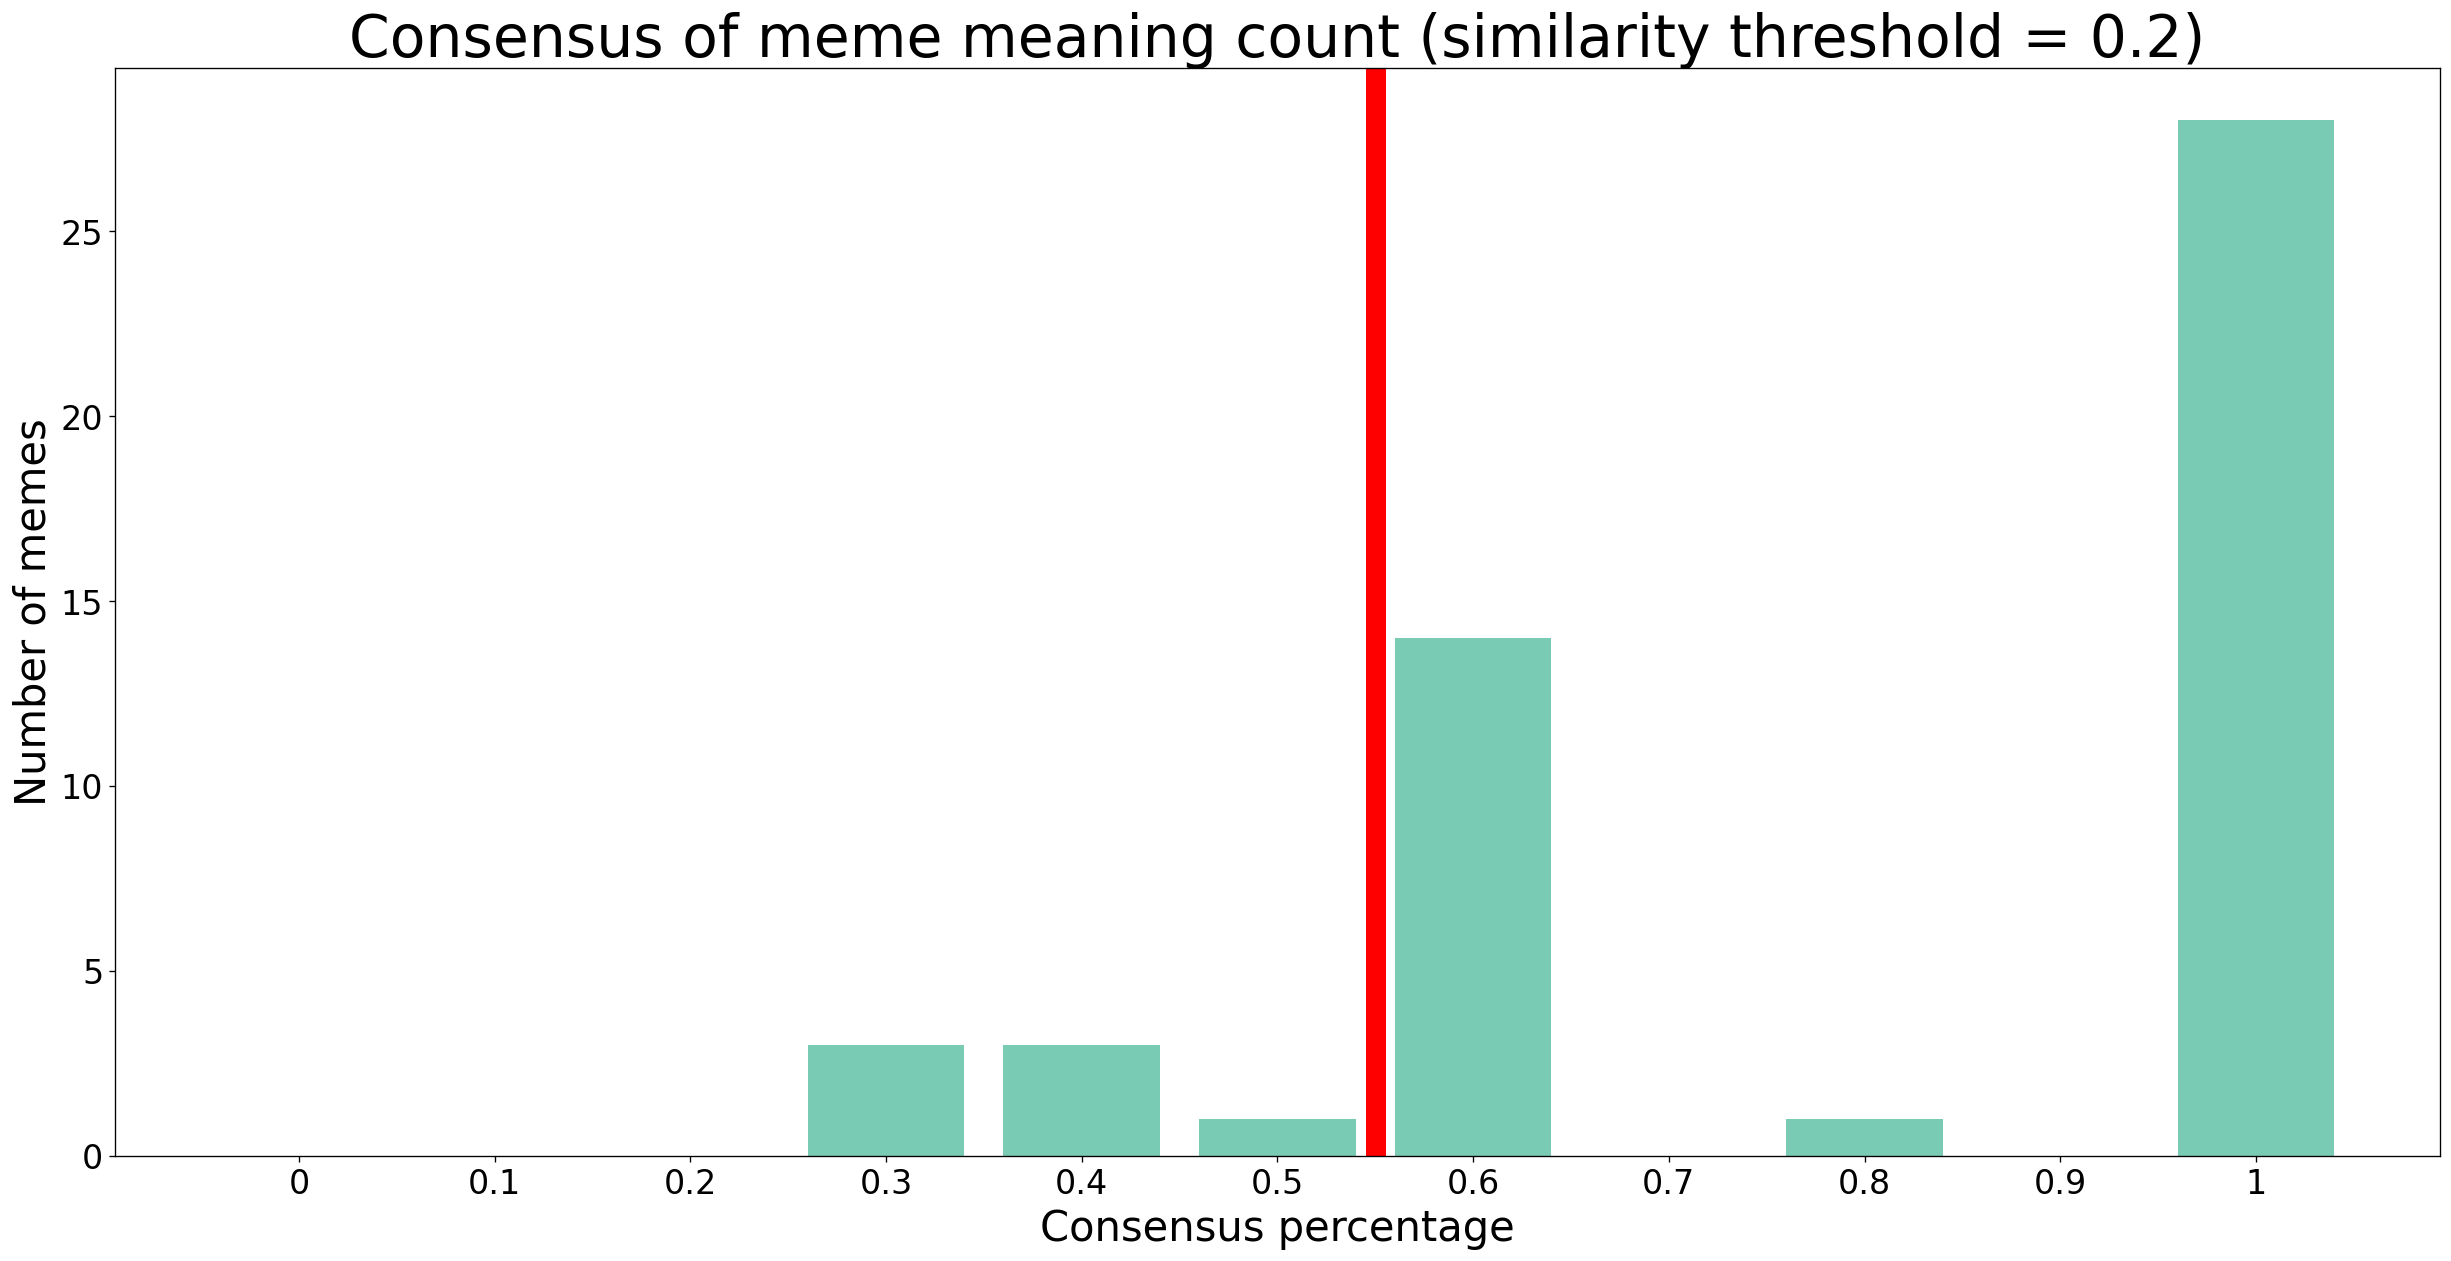

In [30]:
# Calculate consensus for each meme
matrices = similarity_matrices(similarity_threshold)

consensus_data = {}
for key, m in matrices.items():
    proportion = consensus_level(m)
    consensus_data[key] = proportion
    
# Create Counter
consensus_counter = Counter(consensus_data.values())    
    
# Fill in missing values with 0
for i in np.arange(0, 1.1, 0.1):
    i = round(i,1)
    if i not in consensus_counter.keys():
        consensus_counter[i] = 0

# Sort the data
consensus_counter = dict(sorted(consensus_counter.items(), key=lambda item: item[0], reverse=False))

# Visualize
plt.figure(figsize=(25, 12), dpi=120)
plt.bar(['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1'], consensus_counter.values(), color=hex1)
plt.axvline(x=consensus_percentage*10*0.917, color="red", linewidth=12)
plt.ylabel('Number of memes', fontsize=medium_fontsize)
plt.xlabel('Consensus percentage', fontsize=medium_fontsize)
plt.xticks(fontsize=small_fontsize+5)
plt.yticks(fontsize=small_fontsize+5)
plt.title("Consensus of meme meaning count (similarity threshold = {})".format(similarity_threshold), fontsize=large_fontsize)
# plt.savefig('graphs/toloka/title/consensus.png', bbox_inches='tight')
plt.show() 

#### Plot number of accepted memes for different similarity thresholds

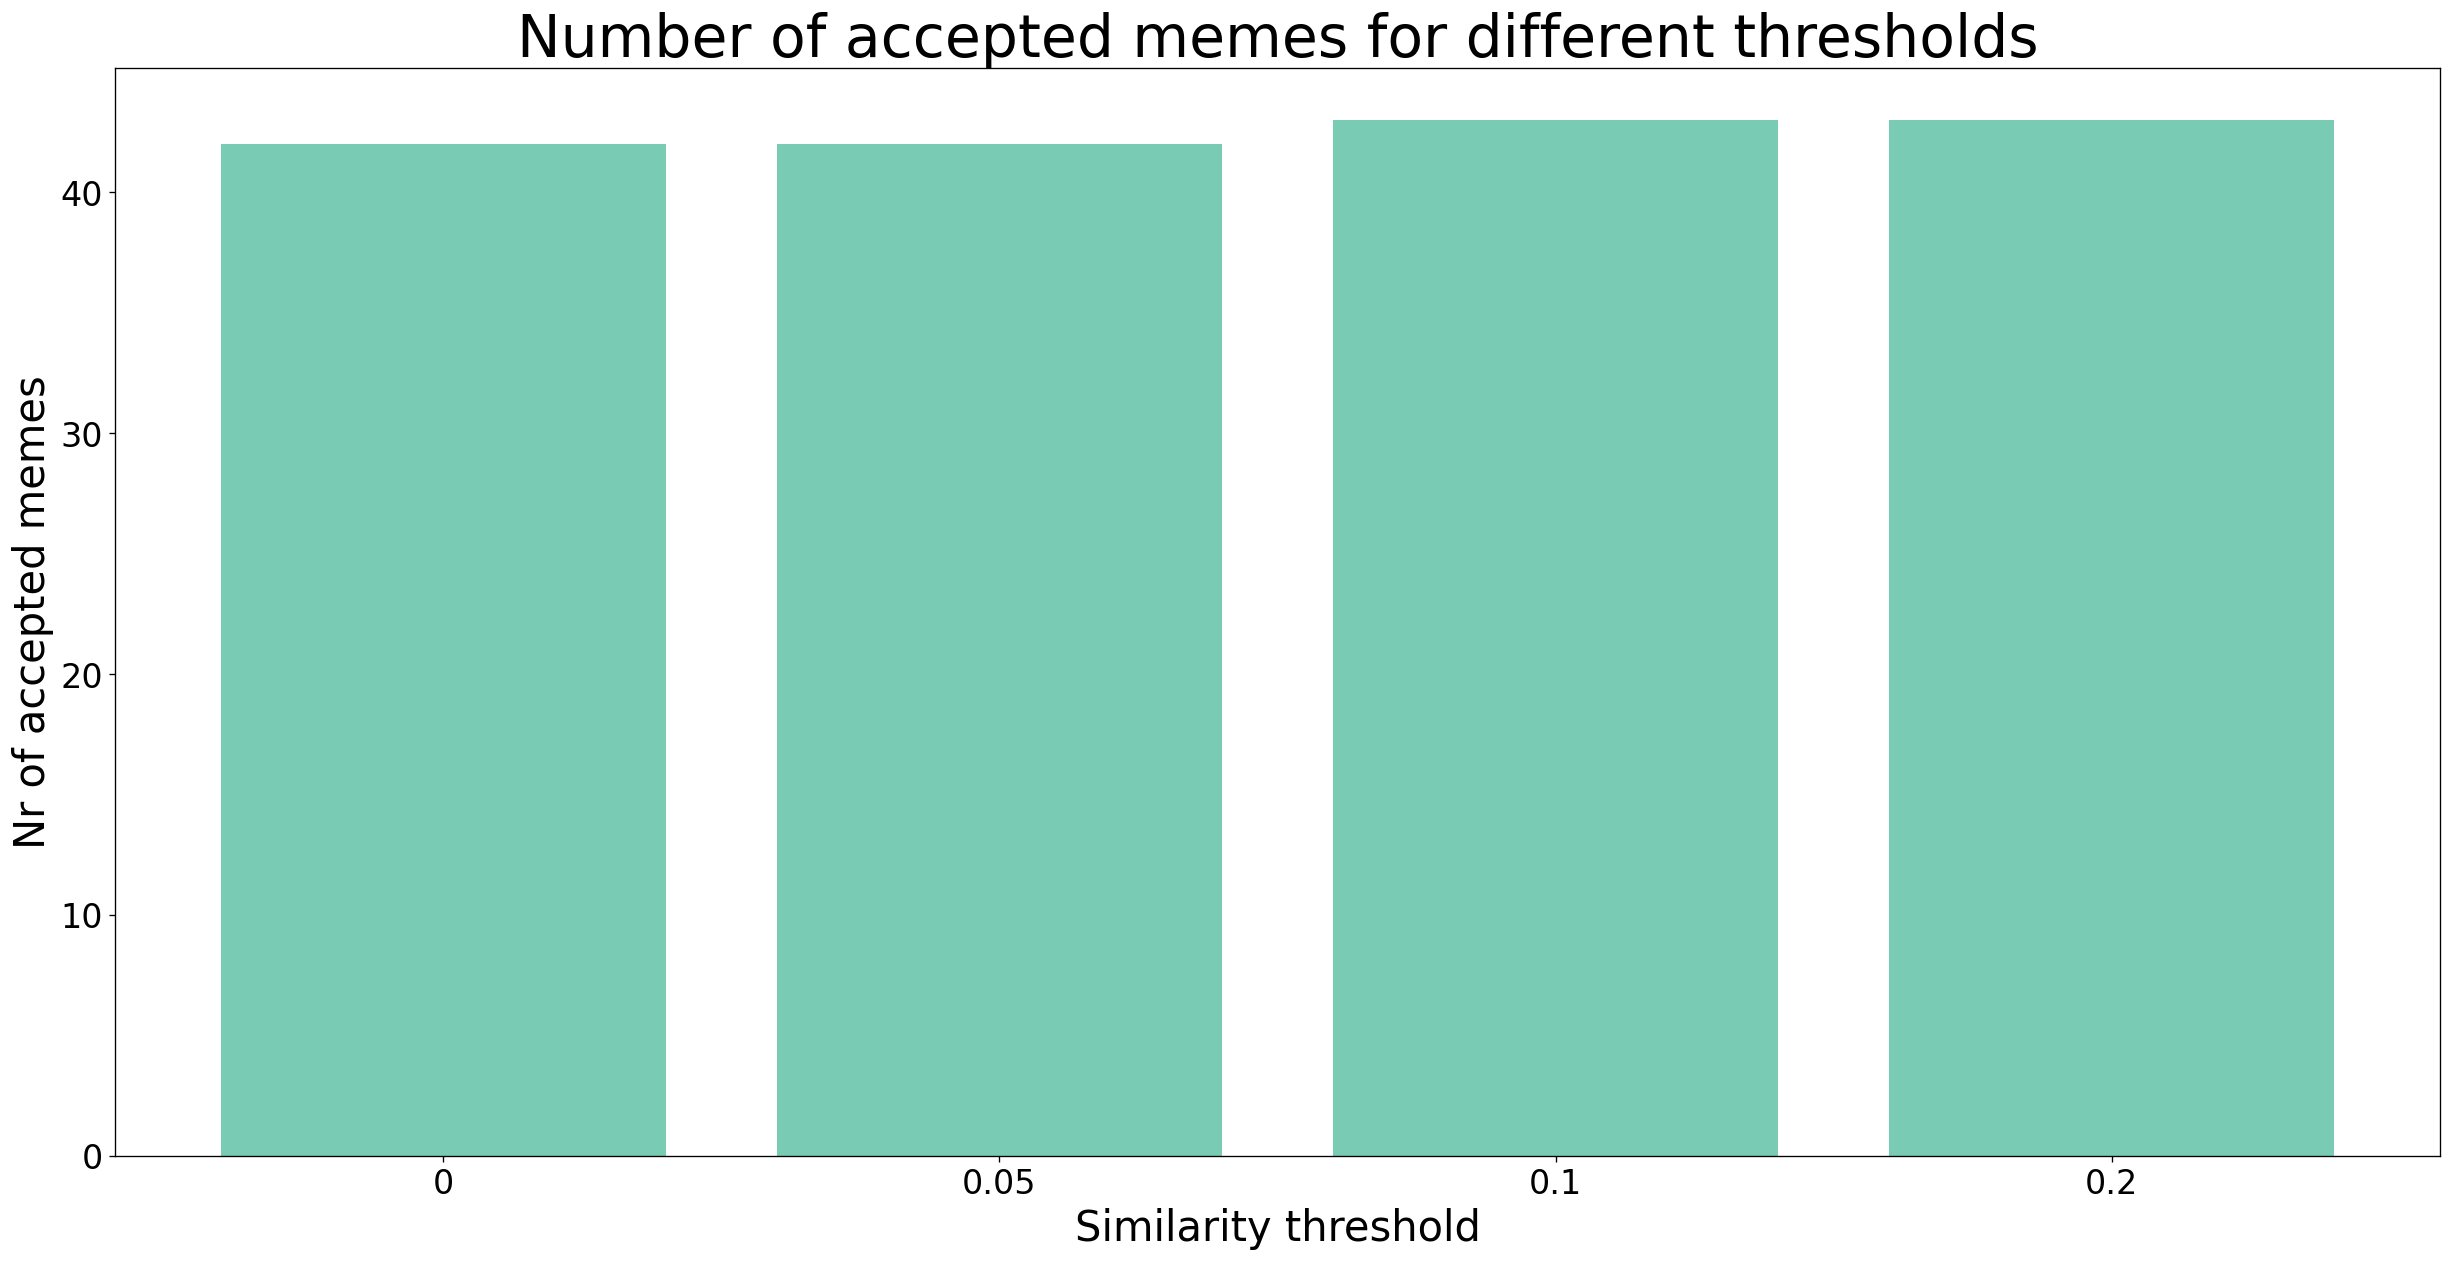

In [31]:
# Get matrices
x_range = [0, 0.05, 0.1, 0.2]
y_vals = []

for sim_thresh in x_range:
    matrices = similarity_matrices(sim_thresh)

    # Calculate consensus for each meme
    consensus_data = {}
    for key, m in matrices.items():
        proportion = consensus_level(m)
        consensus_data[key] = proportion

    # Create Counter
    consensus_counter = Counter(consensus_data.values())    

    # Get number of memes that are >= consensus_percentage
    accepted_num = sum([val for key, val in consensus_counter.items() if key >= consensus_percentage])
    y_vals.append(accepted_num)
    

# Visualize
plt.figure(figsize=(25, 12), dpi=120)
plt.bar([str(n) for n in x_range], y_vals, color=hex1)
plt.ylabel('Nr of accepted memes', fontsize=medium_fontsize)
plt.xlabel('Similarity threshold', fontsize=medium_fontsize)
plt.xticks(fontsize=small_fontsize+5)
plt.yticks(fontsize=small_fontsize+5)
plt.title("Number of accepted memes for different thresholds".format(similarity_threshold), fontsize=large_fontsize)
# plt.savefig('graphs/toloka/title/similarity_thresholds.png', bbox_inches='tight')
plt.show()

#### Plot levenshtein distance histogram

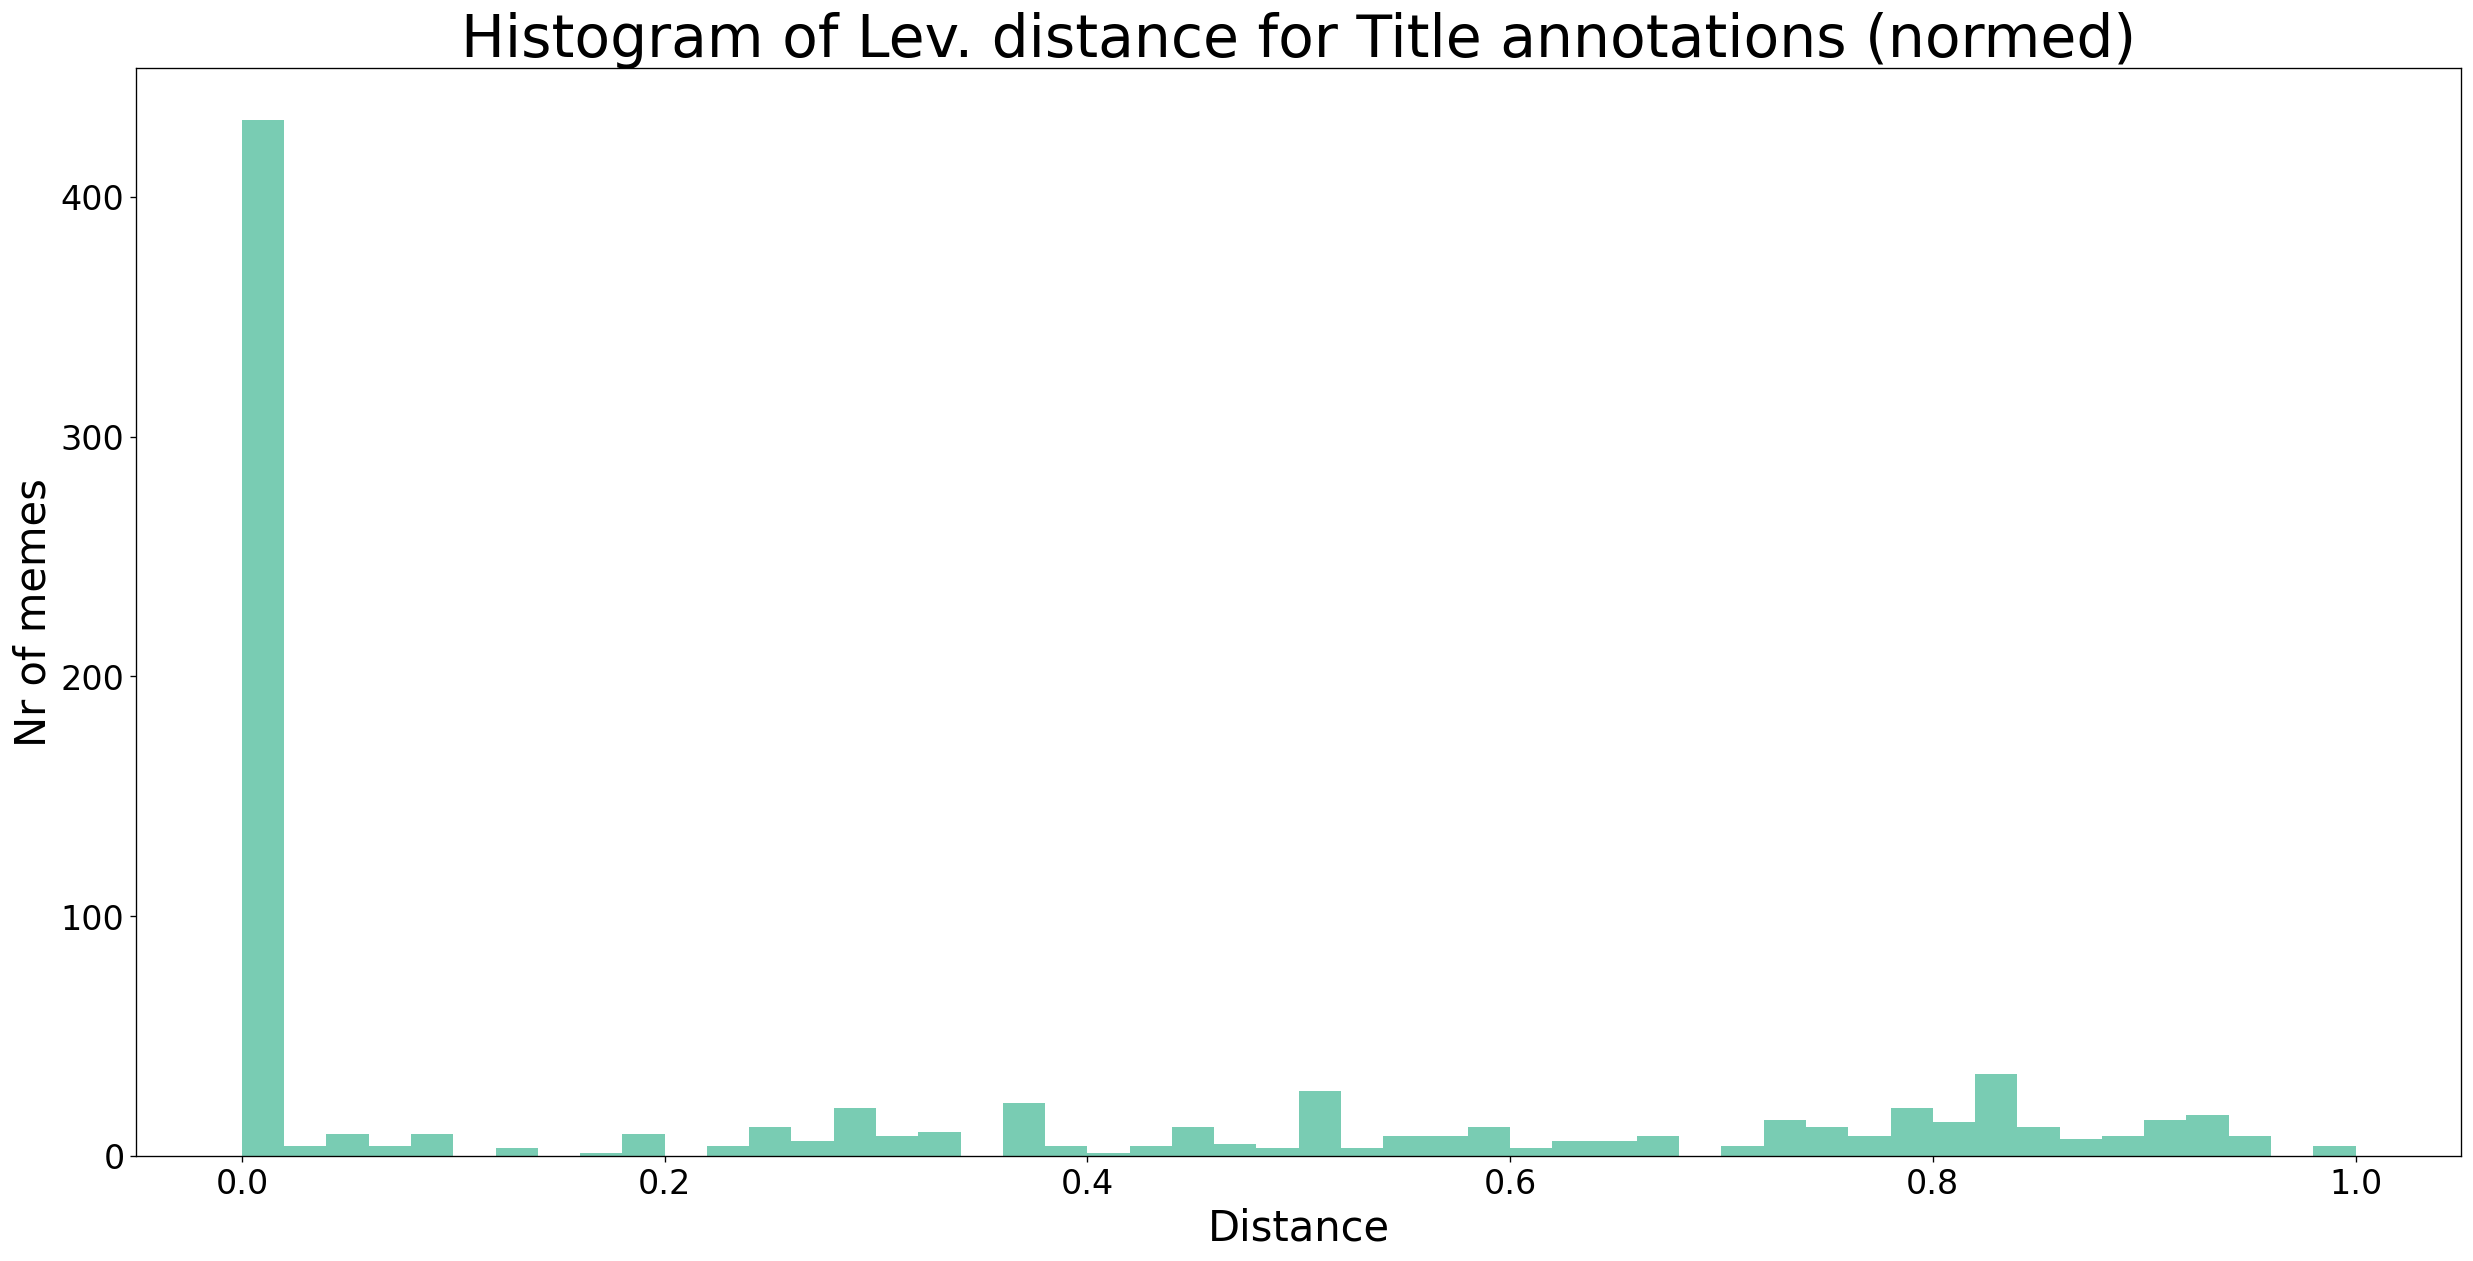

In [32]:
plt.figure(figsize=(25, 12), dpi=120)
plt.hist(hist_data, bins = 50, color=hex1)
plt.title("Histogram of Lev. distance for Title annotations (normed)", fontsize=large_fontsize)
plt.ylabel('Nr of memes', fontsize=medium_fontsize)
plt.xlabel('Distance', fontsize=medium_fontsize)
plt.xticks(fontsize=small_fontsize+5)
plt.yticks(fontsize=small_fontsize+5)
# plt.savefig('graphs/toloka/title/distance_histogram.png', bbox_inches='tight')
plt.show() 

#### Boxplots of distances for each meme

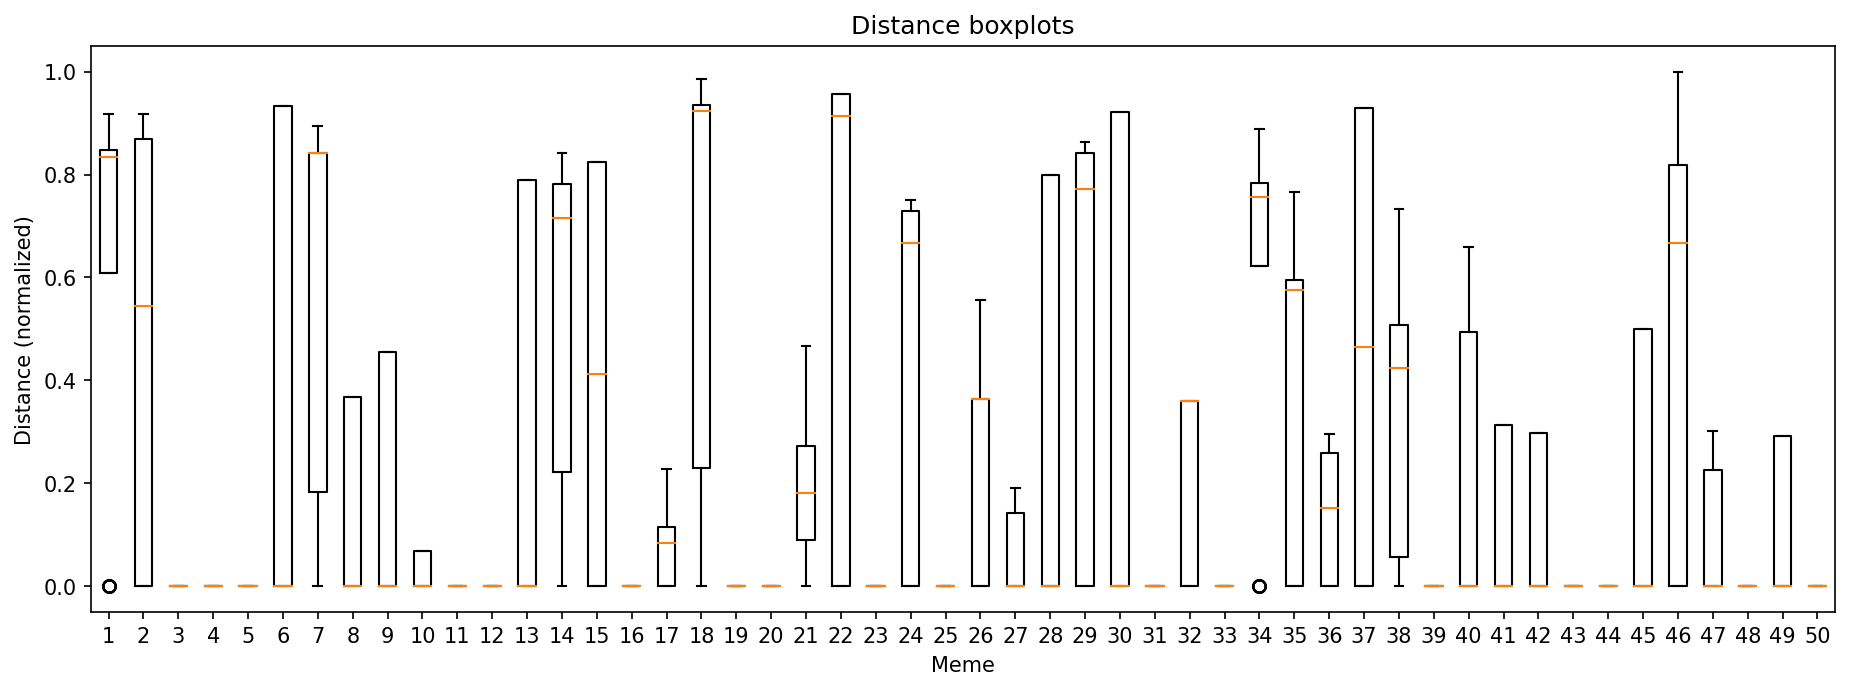

In [33]:
# Boxplot for similarity – all in one (normalized)
distances_per_meme = {key:[dist for dist_list in val.values() for dist in dist_list if dist >= 0] for key, val in distances.items()}

import copy
plt.figure(figsize=(15,5))
c = 0
dist_copy = copy.deepcopy(distances_per_meme)
keys = dist_copy.keys()
data = dist_copy.values()
positions = np.arange(1, 51, step=1)
#labels = [str(i) for i in range(1,51)]
plt.boxplot(data, positions=positions, showfliers=True)
#axis[i][j].set_title(title.split("/")[-1][:30])#, fontsize=large_fontsize)
plt.title('Distance boxplots')
plt.ylabel('Distance (normalized)')
plt.xlabel('Meme')
plt.xticks(np.arange(1, 51, step=1))
#plt.yticks(np.arange(0, 1.1, step=0.1))
#plt.yticks([])
c += 1
# plt.savefig('graphs/toloka/title/boxplots_norm.png')
plt.show() 